In [1]:
# pip install nibabel

In [1]:
import os 
import shutil, sys 
import json
import glob
import nibabel as nib
import nilearn
from nilearn import plotting, image
import re
import pandas as pd
import pydicom, ntpath
from datetime import datetime
import numpy as np
from itertools import groupby

import zipfile
import subprocess
from os.path import join as opj
from pathlib import Path
import operator

from bidsphysio.dcm2bids import dcm2bidsphysio  ## useful repo for physiological data: https://github.com/cbinyu/bidsphysio # try ==1.3.3 if it doesnt work
from pydeface import utils as pdu  # pydeface for defacing

import multiprocessing as mp
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%matplotlib inline

221223-13:06:06,472 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.7.0


## directories

In [2]:
project_dir = '/home/Public/trondheim'
bids_dir = os.path.join(project_dir, 'derivatives/bids')
if not os.path.exists(bids_dir):
    os.makedirs(bids_dir)
    description = {
      "Name": "IMCN functional dataset ERC",
      "BIDSVersion": "1.4.1",
      "Authors": ["Anne C. Trutti", "Birte U. Forstmann", "Desmond H. Y. Tse", "Pierre-Louis Bazin", "Scott Isherwood", "Steven Miletic"],
      "HowToAcknowledge": "Please cite our paper"
    }

    with open(os.path.join(bids_dir, 'dataset_description.json'), 'w') as f:
        json.dump(description, f)
    
    # add .bidsignore-file to ignore the mp2rage inversions
    with open(os.path.join(bids_dir, '.bidsignore'), 'w') as f:
        f.write('*mprage*')

session codes:'ses-' 

- 'rlsat'   - RL-SAT session [Steven] 
- 'sstmsit' - SST + MSIT session [Scott]
- 'rbrevl'  - WM+ RevL session [Anne]
- 'anatomical'  - structural session; MP2rage + resting state 

*NEW*:
Code has changed slightly to add Beth's session (mrlc)

BEth does not collect a T1w scan, so the T1w from the anatomical session must be copied over for all mrlc sessions so that fmriprep can run

Must define map dict if the session did not go as expected (e.g. extra scan), otherwise is done automatically

In [4]:
!ls -la /home/Public/trondheim/sourcedata/zipdata/sub-048/ses-sstmsit/nifti_tmp

total 5209000
drwxrwsr-x 2 stevenm cdrom       4096 feb 21  2022 .
drwxrwsr-x 4 stevenm cdrom       4096 feb 21  2022 ..
-rw-rw-r-- 1 stevenm cdrom       3149 feb 21  2022 SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_10.json
-rw-rw-r-- 1 stevenm cdrom    2409394 feb 21  2022 SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_10.nii.gz
-rw-rw-r-- 1 stevenm cdrom       3178 feb 21  2022 SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_11.json
-rw-rw-r-- 1 stevenm cdrom 1319515269 feb 21  2022 SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_11.nii.gz
-rw-rw-r-- 1 stevenm cdrom       3146 feb 21  2022 SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_16.json
-rw-rw-r-- 1 stevenm cdrom    2409873 feb 21  2022 SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_16.nii.gz
-rw-rw-r-- 1 stevenm cdrom       3168 feb 21  2022 SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_17.json
-rw-rw-r-- 1 stevenm cdrom 1320070312 feb 21  2022 SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_1

In [3]:
abnormal_map_dicts = {
    'sub-001': {
        'ses-rbrevl': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_4': 'func/sub-001_ses-rbrevl_task-revl_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_5': 'func/sub-001_ses-rbrevl_task-revl_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_10': 'func/sub-001_ses-rbrevl_task-revl_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_11': 'func/sub-001_ses-rbrevl_task-revl_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_16': 'func/sub-001_ses-rbrevl_task-rb_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_17': 'func/sub-001_ses-rbrevl_task-rb_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_22': 'func/sub-001_ses-rbrevl_task-rb_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_23': 'func/sub-001_ses-rbrevl_task-rb_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20201202120023_8': 'fmap/sub-001_ses-rbrevl_acq-revl_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20201202120023_14': 'fmap/sub-001_ses-rbrevl_acq-revl_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20201202120023_20': 'fmap/sub-001_ses-rbrevl_acq-rb_run-1_epi',
            
            'SCANS_t1_mp2rage_sag_p3_1mm_20201202120023_22': 'anat/sub-001_ses-rbrevl_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20201202120023_23': 'anat/sub-001_ses-rbrevl_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20201202120023_24': 'anat/sub-001_ses-rbrevl_T1w'
        }
    },
    'sub-002': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210219093635_4': 'func/sub-002_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210219093635_5': 'func/sub-002_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210219093635_24': 'func/sub-002_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210219093635_25': 'func/sub-002_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210219093635_8': 'fmap/sub-002_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210219093635_28': 'fmap/sub-002_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210219093635_12': 'anat/sub-002_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210219093635_13': 'anat/sub-002_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210219093635_14': 'anat/sub-002_ses-anatomical_T1w'
        }
    },
    'sub-003': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210114101359_4': 'func/sub-003_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210114101359_5': 'func/sub-003_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210114101359_18': 'func/sub-003_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210114101359_19': 'func/sub-003_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210114101359_8': 'fmap/sub-003_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210114101359_24': 'fmap/sub-003_ses-anatomical_acq-rs_run-2_epi',
            
            'SCANS_t1_mp2rage_sag_0p75_20210114101359_10': 'anat/sub-003_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210114101359_11': 'anat/sub-003_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210114101359_12': 'anat/sub-003_ses-anatomical_T1w'
        }
    },
    'sub-004': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210126093836_4': 'func/sub-004_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210126093836_5': 'func/sub-004_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210126093836_18': 'func/sub-004_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210126093836_19': 'func/sub-004_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210126093836_8': 'fmap/sub-004_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210126093836_22': 'fmap/sub-004_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210126093836_10': 'anat/sub-004_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210126093836_12': 'anat/sub-004_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210126093836_11': 'anat/sub-004_ses-anatomical_T1w'
        },
        'ses-sstmsit': { # no t1 image collected for this session
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210202093312_4': 'func/sub-004_ses-sstmsit_task-msit_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210202093312_5': 'func/sub-004_ses-sstmsit_task-msit_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210202093312_13': 'func/sub-004_ses-sstmsit_task-msit_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210202093312_14': 'func/sub-004_ses-sstmsit_task-msit_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210202093312_19': 'func/sub-004_ses-sstmsit_task-sst_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210202093312_20': 'func/sub-004_ses-sstmsit_task-sst_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210202093312_25': 'func/sub-004_ses-sstmsit_task-sst_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210202093312_26': 'func/sub-004_ses-sstmsit_task-sst_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210202093312_8': 'fmap/sub-004_ses-sstmsit_acq-msit_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210202093312_17': 'fmap/sub-004_ses-sstmsit_acq-msit_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210202093312_23': 'fmap/sub-004_ses-sstmsit_acq-sst_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210202093312_29': 'fmap/sub-004_ses-sstmsit_acq-sst_run-2_epi'
        },
        'ses-rlsat': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210325093712_7': 'func/sub-004_ses-rlsat_task-rlsat_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210325093712_8': 'func/sub-004_ses-rlsat_task-rlsat_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210325093712_13': 'func/sub-004_ses-rlsat_task-rlsat_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210325093712_14': 'func/sub-004_ses-rlsat_task-rlsat_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210325093712_19': 'func/sub-004_ses-rlsat_task-rlsat_run-3_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210325093712_20': 'func/sub-004_ses-rlsat_task-rlsat_run-3_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210325093712_11': 'fmap/sub-004_ses-rlsat_acq-rlsat_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210325093712_17': 'fmap/sub-004_ses-rlsat_acq-rlsat_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210325093712_23': 'fmap/sub-004_ses-rlsat_acq-rlsat_run-3_epi',

            'SCANS_t1_mp2rage_sag_p3_1mm_20210325093712_25': 'anat/sub-004_ses-rlsat_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210325093712_26': 'anat/sub-004_ses-rlsat_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210325093712_27': 'anat/sub-004_ses-rlsat_T1w'
        }
    },
        'sub-005': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210126124109_4': 'func/sub-005_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210126124109_5': 'func/sub-005_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210126124109_18': 'func/sub-005_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210126124109_19': 'func/sub-005_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210126124109_8': 'fmap/sub-005_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210126124109_22': 'fmap/sub-005_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210126124109_10': 'anat/sub-005_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210126124109_11': 'anat/sub-005_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210126124109_12': 'anat/sub-005_ses-anatomical_T1w'
        }
    },
    'sub-006': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210126075101_4': 'func/sub-006_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210126075101_5': 'func/sub-006_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210126075101_18': 'func/sub-006_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210126075101_19': 'func/sub-006_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210126075101_8': 'fmap/sub-006_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210126075101_22': 'fmap/sub-006_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210126075101_10': 'anat/sub-006_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210126075101_12': 'anat/sub-006_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210126075101_11': 'anat/sub-006_ses-anatomical_T1w'
        },
        'ses-sstmsit': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210209075245_4': 'func/sub-006_ses-sstmsit_task-msit_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210209075245_5': 'func/sub-006_ses-sstmsit_task-msit_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210209075245_10': 'func/sub-006_ses-sstmsit_task-msit_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210209075245_11': 'func/sub-006_ses-sstmsit_task-msit_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210209075245_16': 'func/sub-006_ses-sstmsit_task-sst_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210209075245_17': 'func/sub-006_ses-sstmsit_task-sst_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210209075245_25': 'func/sub-006_ses-sstmsit_task-sst_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210209075245_26': 'func/sub-006_ses-sstmsit_task-sst_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210209075245_8': 'fmap/sub-006_ses-sstmsit_acq-msit_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210209075245_14': 'fmap/sub-006_ses-sstmsit_acq-msit_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210209075245_20': 'fmap/sub-006_ses-sstmsit_acq-sst_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210209075245_29': 'fmap/sub-006_ses-sstmsit_acq-sst_run-2_epi',
            
            'SCANS_t1_mp2rage_sag_p3_1mm_20210209075245_31': 'anat/sub-006_ses-sstmsit_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210209075245_32': 'anat/sub-006_ses-sstmsit_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210209075245_33': 'anat/sub-006_ses-sstmsit_T1w'
        }
    },
    'sub-007': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210128124801_4': 'func/sub-007_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210128124801_5': 'func/sub-007_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210128124801_18': 'func/sub-007_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210128124801_19': 'func/sub-007_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210128124801_8': 'fmap/sub-007_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210128124801_22': 'fmap/sub-007_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210128124801_10': 'anat/sub-007_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210128124801_11': 'anat/sub-007_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210128124801_12': 'anat/sub-007_ses-anatomical_T1w'
        },
        'ses-rbrevl': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204124832_4': 'func/sub-007_ses-rbrevl_task-revl_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204124832_5': 'func/sub-007_ses-rbrevl_task-revl_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204124832_10': 'func/sub-007_ses-rbrevl_task-revl_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204124832_11': 'func/sub-007_ses-rbrevl_task-revl_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204124832_16': 'func/sub-007_ses-rbrevl_task-rb_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204124832_17': 'func/sub-007_ses-rbrevl_task-rb_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204124832_25': 'func/sub-007_ses-rbrevl_task-rb_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204124832_26': 'func/sub-007_ses-rbrevl_task-rb_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210204124832_8': 'fmap/sub-007_ses-rbrevl_acq-revl_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210204124832_14': 'fmap/sub-007_ses-rbrevl_acq-revl_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210204124832_20': 'fmap/sub-007_ses-rbrevl_acq-rb_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210204124832_29': 'fmap/sub-007_ses-rbrevl_acq-rb_run-2_epi',

            'SCANS_t1_mp2rage_sag_p3_1mm_20210204124832_31': 'anat/sub-007_ses-rbrevl_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210204124832_32': 'anat/sub-007_ses-rbrevl_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210204124832_33': 'anat/sub-007_ses-rbrevl_T1w'
        },
        'ses-sstmsit': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210218134022_4': 'func/sub-007_ses-sstmsit_task-msit_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210218134022_5': 'func/sub-007_ses-sstmsit_task-msit_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210218134022_10': 'func/sub-007_ses-sstmsit_task-msit_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210218134022_11': 'func/sub-007_ses-sstmsit_task-msit_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210218134022_19': 'func/sub-007_ses-sstmsit_task-sst_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210218134022_20': 'func/sub-007_ses-sstmsit_task-sst_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210218134022_25': 'func/sub-007_ses-sstmsit_task-sst_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210218134022_26': 'func/sub-007_ses-sstmsit_task-sst_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210218134022_8': 'fmap/sub-007_ses-sstmsit_acq-msit_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210218134022_14': 'fmap/sub-007_ses-sstmsit_acq-msit_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210218134022_23': 'fmap/sub-007_ses-sstmsit_acq-sst_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210218134022_29': 'fmap/sub-007_ses-sstmsit_acq-sst_run-2_epi',
            
            'SCANS_t1_mp2rage_sag_p3_1mm_20210218134022_31': 'anat/sub-007_ses-sstmsit_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210218134022_33': 'anat/sub-007_ses-sstmsit_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210218134022_32': 'anat/sub-007_ses-sstmsit_T1w'
        }
    },
    'sub-008': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210128081527_4': 'func/sub-008_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210128081527_5': 'func/sub-008_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210128081527_18': 'func/sub-008_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210128081527_19': 'func/sub-008_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210128081527_8': 'fmap/sub-008_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210128081527_22': 'fmap/sub-008_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210128081527_10': 'anat/sub-008_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210128081527_11': 'anat/sub-008_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210128081527_12': 'anat/sub-008_ses-anatomical_T1w'
        },
        'ses-rbrevl': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204075251_4': 'func/sub-008_ses-rbrevl_task-revl_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204075251_5': 'func/sub-008_ses-rbrevl_task-revl_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204075251_10': 'func/sub-008_ses-rbrevl_task-revl_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204075251_11': 'func/sub-008_ses-rbrevl_task-revl_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204075251_16': 'func/sub-008_ses-rbrevl_task-rb_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204075251_17': 'func/sub-008_ses-rbrevl_task-rb_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204075251_22': 'func/sub-008_ses-rbrevl_task-rb_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210204075251_23': 'func/sub-008_ses-rbrevl_task-rb_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210204075251_8': 'fmap/sub-008_ses-rbrevl_acq-revl_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210204075251_14': 'fmap/sub-008_ses-rbrevl_acq-revl_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210204075251_20': 'fmap/sub-008_ses-rbrevl_acq-rb_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210204075251_26': 'fmap/sub-008_ses-rbrevl_acq-rb_run-2_epi',

            'SCANS_t1_mp2rage_sag_p3_1mm_20210204075251_28': 'anat/sub-008_ses-rbrevl_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210204075251_29': 'anat/sub-008_ses-rbrevl_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210204075251_30': 'anat/sub-008_ses-rbrevl_T1w'
        },
        'ses-rlsat': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210212074944_4': 'func/sub-008_ses-rlsat_task-rlsat_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210212074944_5': 'func/sub-008_ses-rlsat_task-rlsat_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210212074944_10': 'func/sub-008_ses-rlsat_task-rlsat_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210212074944_11': 'func/sub-008_ses-rlsat_task-rlsat_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210212074944_16': 'func/sub-008_ses-rlsat_task-rlsat_run-3_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210212074944_17': 'func/sub-008_ses-rlsat_task-rlsat_run-3_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210212074944_8': 'fmap/sub-008_ses-rlsat_acq-rlsat_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210212074944_14': 'fmap/sub-008_ses-rlsat_acq-rlsat_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210212074944_20': 'fmap/sub-008_ses-rlsat_acq-rlsat_run-3_epi',

            'SCANS_t1_mp2rage_sag_p3_1mm_20210212074944_22': 'anat/sub-008_ses-rlsat_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210212074944_23': 'anat/sub-008_ses-rlsat_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210212074944_24': 'anat/sub-008_ses-rlsat_T1w'
        }
    },
    'sub-009': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210216080813_4': 'func/sub-009_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210216080813_5': 'func/sub-009_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210216080813_20': 'func/sub-009_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210216080813_21': 'func/sub-009_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210216080813_8': 'fmap/sub-009_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210216080813_24': 'fmap/sub-009_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210216080813_12': 'anat/sub-009_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210216080813_13': 'anat/sub-009_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210216080813_14': 'anat/sub-009_ses-anatomical_T1w'
        },
        'ses-rbrevl': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210302075221_5': 'func/sub-009_ses-rbrevl_task-revl_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210302075221_6': 'func/sub-009_ses-rbrevl_task-revl_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210302075221_11': 'func/sub-009_ses-rbrevl_task-revl_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210302075221_12': 'func/sub-009_ses-rbrevl_task-revl_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210302075221_17': 'func/sub-009_ses-rbrevl_task-rb_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210302075221_18': 'func/sub-009_ses-rbrevl_task-rb_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210302075221_23': 'func/sub-009_ses-rbrevl_task-rb_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210302075221_24': 'func/sub-009_ses-rbrevl_task-rb_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210302075221_9': 'fmap/sub-009_ses-rbrevl_acq-revl_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210302075221_15': 'fmap/sub-009_ses-rbrevl_acq-revl_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210302075221_21': 'fmap/sub-009_ses-rbrevl_acq-rb_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210302075221_27': 'fmap/sub-009_ses-rbrevl_acq-rb_run-2_epi',

            'SCANS_t1_mp2rage_sag_p3_1mm_20210302075221_29': 'anat/sub-009_ses-rbrevl_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210302075221_30': 'anat/sub-009_ses-rbrevl_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210302075221_31': 'anat/sub-009_ses-rbrevl_T1w'            
        }
    },
    'sub-010': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210223120842_4': 'func/sub-010_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210223120842_5': 'func/sub-010_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210223120842_20': 'func/sub-010_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210223120842_21': 'func/sub-010_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210223120842_8': 'fmap/sub-010_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210223120842_24': 'fmap/sub-010_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210223120842_12': 'anat/sub-010_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210223120842_13': 'anat/sub-010_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210223120842_14': 'anat/sub-010_ses-anatomical_T1w'
        }
    },
    'sub-011': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210219081156_4': 'func/sub-011_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210219081156_5': 'func/sub-011_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210219081156_20': 'func/sub-011_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210219081156_21': 'func/sub-011_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210219081156_8': 'fmap/sub-011_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210219081156_24': 'fmap/sub-011_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210219081156_12': 'anat/sub-011_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210219081156_13': 'anat/sub-011_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210219081156_14': 'anat/sub-011_ses-anatomical_T1w'
        }
    },
    'sub-013': {
        'ses-sstmsit': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210406134602_4': 'func/sub-013_ses-sstmsit_task-msit_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210406134602_5': 'func/sub-013_ses-sstmsit_task-msit_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210406134602_10': 'func/sub-013_ses-sstmsit_task-msit_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210406134602_11': 'func/sub-013_ses-sstmsit_task-msit_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210406134602_19': 'func/sub-013_ses-sstmsit_task-sst_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210406134602_20': 'func/sub-013_ses-sstmsit_task-sst_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210406134602_25': 'func/sub-013_ses-sstmsit_task-sst_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210406134602_26': 'func/sub-013_ses-sstmsit_task-sst_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210406134602_8': 'fmap/sub-013_ses-sstmsit_acq-msit_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210406134602_14': 'fmap/sub-013_ses-sstmsit_acq-msit_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210406134602_23': 'fmap/sub-013_ses-sstmsit_acq-sst_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210406134602_29': 'fmap/sub-013_ses-sstmsit_acq-sst_run-2_epi',
            
            'SCANS_t1_mp2rage_sag_p3_1mm_20210406134602_28': 'anat/sub-013_ses-sstmsit_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210406134602_30': 'anat/sub-013_ses-sstmsit_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210406134602_29': 'anat/sub-013_ses-sstmsit_T1w'
        }
    },
    'sub-014': {
        'ses-rbrevl':{
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210408133309_4': 'func/sub-014_ses-rbrevl_task-rb_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210408133309_5': 'func/sub-014_ses-rbrevl_task-rb_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210408133309_10': 'func/sub-014_ses-rbrevl_task-rb_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210408133309_11': 'func/sub-014_ses-rbrevl_task-rb_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210408133309_16': 'func/sub-014_ses-rbrevl_task-revl_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210408133309_17': 'func/sub-014_ses-rbrevl_task-revl_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210408133309_23': 'func/sub-014_ses-rbrevl_task-revl_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210408133309_24': 'func/sub-014_ses-rbrevl_task-revl_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210408133309_8': 'fmap/sub-014_ses-rbrevl_acq-rb_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210408133309_14': 'fmap/sub-014_ses-rbrevl_acq-rb_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210408133309_20': 'fmap/sub-014_ses-rbrevl_acq-revl_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210408133309_27': 'fmap/sub-014_ses-rbrevl_acq-revl_run-2_epi',

            'SCANS_t1_mp2rage_sag_p3_1mm_20210408133309_29': 'anat/sub-014_ses-rbrevl_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210408133309_31': 'anat/sub-014_ses-rbrevl_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210408133309_30': 'anat/sub-014_ses-rbrevl_T1w'   
        } 
    },
    'sub-015': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210305080422_9': 'func/sub-015_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210305080422_10': 'func/sub-015_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210305080422_25': 'func/sub-015_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210305080422_26': 'func/sub-015_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210305080422_13': 'fmap/sub-015_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210305080422_29': 'fmap/sub-015_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210305080422_17': 'anat/sub-015_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210305080422_19': 'anat/sub-015_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210305080422_18': 'anat/sub-015_ses-anatomical_T1w'
        }
    },
    'sub-017': {
        'ses-rlsat': { # no t1w image collected for this session
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210323074757_4': f'func/sub-017_ses-rlsat_task-rlsat_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210323074757_5': f'func/sub-017_ses-rlsat_task-rlsat_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210323074757_10': f'func/sub-017_ses-rlsat_task-rlsat_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210323074757_11': f'func/sub-017_ses-rlsat_task-rlsat_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210323074757_16': f'func/sub-017_ses-rlsat_task-rlsat_run-3_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210323074757_17': f'func/sub-017_ses-rlsat_task-rlsat_run-3_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210323074757_8': f'fmap/sub-017_ses-rlsat_acq-rlsat_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210323074757_14': f'fmap/sub-017_ses-rlsat_acq-rlsat_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210323074757_20': f'fmap/sub-017_ses-rlsat_acq-rlsat_run-3_epi'
            }
        },
    'sub-018': {
        'ses-sstmsit': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210415131441_6': 'func/sub-018_ses-sstmsit_task-msit_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210415131441_7': 'func/sub-018_ses-sstmsit_task-msit_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210415131441_12': 'func/sub-018_ses-sstmsit_task-msit_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210415131441_13': 'func/sub-018_ses-sstmsit_task-msit_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210415131441_18': 'func/sub-018_ses-sstmsit_task-sst_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210415131441_19': 'func/sub-018_ses-sstmsit_task-sst_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210415131441_24': 'func/sub-018_ses-sstmsit_task-sst_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210415131441_25': 'func/sub-018_ses-sstmsit_task-sst_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210415131441_10': 'fmap/sub-018_ses-sstmsit_acq-msit_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210415131441_16': 'fmap/sub-018_ses-sstmsit_acq-msit_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210415131441_22': 'fmap/sub-018_ses-sstmsit_acq-sst_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210415131441_28': 'fmap/sub-018_ses-sstmsit_acq-sst_run-2_epi',
            
            'SCANS_t1_mp2rage_sag_p3_1mm_20210415131441_30': 'anat/sub-018_ses-sstmsit_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210415131441_31': 'anat/sub-018_ses-sstmsit_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210415131441_32': 'anat/sub-018_ses-sstmsit_T1w'
        }
    },
    'sub-021': {
        'ses-sstmsit': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210429095917_4': 'func/sub-021_ses-sstmsit_task-sst_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210429095917_5': 'func/sub-021_ses-sstmsit_task-sst_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210429095917_13': 'func/sub-021_ses-sstmsit_task-sst_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210429095917_14': 'func/sub-021_ses-sstmsit_task-sst_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210429095917_19': 'func/sub-021_ses-sstmsit_task-msit_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210429095917_20': 'func/sub-021_ses-sstmsit_task-msit_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210429095917_25': 'func/sub-021_ses-sstmsit_task-msit_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210429095917_26': 'func/sub-021_ses-sstmsit_task-msit_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210429095917_8': 'fmap/sub-021_ses-sstmsit_acq-sst_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210429095917_17': 'fmap/sub-021_ses-sstmsit_acq-sst_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210429095917_23': 'fmap/sub-021_ses-sstmsit_acq-msit_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210429095917_29': 'fmap/sub-021_ses-sstmsit_acq-msit_run-2_epi',
            
            'SCANS_t1_mp2rage_sag_p3_1mm_20210429095917_31': 'anat/sub-021_ses-sstmsit_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210429095917_32': 'anat/sub-021_ses-sstmsit_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210429095917_33': 'anat/sub-021_ses-sstmsit_T1w'
        }
    },
    'sub-023': {
        'ses-sstmsit': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210603080413_7': 'func/sub-023_ses-sstmsit_task-sst_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210603080413_8': 'func/sub-023_ses-sstmsit_task-sst_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210603080413_13': 'func/sub-023_ses-sstmsit_task-sst_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210603080413_14': 'func/sub-023_ses-sstmsit_task-sst_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210603080413_19': 'func/sub-023_ses-sstmsit_task-msit_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210603080413_20': 'func/sub-023_ses-sstmsit_task-msit_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210603080413_25': 'func/sub-023_ses-sstmsit_task-msit_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210603080413_26': 'func/sub-023_ses-sstmsit_task-msit_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210603080413_11': 'fmap/sub-023_ses-sstmsit_acq-sst_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210603080413_17': 'fmap/sub-023_ses-sstmsit_acq-sst_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210603080413_23': 'fmap/sub-023_ses-sstmsit_acq-msit_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210603080413_29': 'fmap/sub-023_ses-sstmsit_acq-msit_run-2_epi',
            
            'SCANS_t1_mp2rage_sag_p3_1mm_20210603080413_31': 'anat/sub-023_ses-sstmsit_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210603080413_32': 'anat/sub-023_ses-sstmsit_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210603080413_33': 'anat/sub-023_ses-sstmsit_T1w'
        }
    },
    'sub-024': {
        'ses-rbrevl':{
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210826133935_4': 'func/sub-024_ses-rbrevl_task-rb_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210826133935_5': 'func/sub-024_ses-rbrevl_task-rb_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210826133935_10': 'func/sub-024_ses-rbrevl_task-rb_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210826133935_11': 'func/sub-024_ses-rbrevl_task-rb_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210826133935_16': 'func/sub-024_ses-rbrevl_task-revl_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210826133935_17': 'func/sub-024_ses-rbrevl_task-revl_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210826133935_23': 'func/sub-024_ses-rbrevl_task-revl_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210826133935_24': 'func/sub-024_ses-rbrevl_task-revl_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210826133935_8': 'fmap/sub-024_ses-rbrevl_acq-rb_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210826133935_14': 'fmap/sub-024_ses-rbrevl_acq-rb_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210826133935_20': 'fmap/sub-024_ses-rbrevl_acq-revl_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210826133935_26': 'fmap/sub-024_ses-rbrevl_acq-revl_run-2_epi',

            'SCANS_t1_mp2rage_sag_p3_1mm_20210826133935_28': 'anat/sub-024_ses-rbrevl_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210826133935_29': 'anat/sub-024_ses-rbrevl_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210826133935_30': 'anat/sub-024_ses-rbrevl_T1w'   
        } 
    },
    'sub-025': {
        'ses-sstmsit': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014114424_4': 'func/sub-025_ses-sstmsit_task-msit_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014114424_5': 'func/sub-025_ses-sstmsit_task-msit_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014114424_10': 'func/sub-025_ses-sstmsit_task-msit_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014114424_11': 'func/sub-025_ses-sstmsit_task-msit_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014114424_16': 'func/sub-025_ses-sstmsit_task-sst_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014114424_17': 'func/sub-025_ses-sstmsit_task-sst_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014114424_22': 'func/sub-025_ses-sstmsit_task-sst_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014114424_23': 'func/sub-025_ses-sstmsit_task-sst_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211014114424_8': 'fmap/sub-025_ses-sstmsit_acq-msit_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211014114424_14': 'fmap/sub-025_ses-sstmsit_acq-msit_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211014114424_20': 'fmap/sub-025_ses-sstmsit_acq-sst_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211014114424_26': 'fmap/sub-025_ses-sstmsit_acq-sst_run-2_epi',
        }
    },
    'sub-026': {
        'ses-mrlc': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220210092548_10': f'func/sub-026_ses-mrlc_task-mt_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220210092548_11': f'func/sub-026_ses-mrlc_task-mt_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220210092548_16': f'func/sub-026_ses-mrlc_task-mt_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220210092548_17': f'func/sub-026_ses-mrlc_task-mt_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220210092548_22': f'func/sub-026_ses-mrlc_task-mt_run-3_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220210092548_23': f'func/sub-026_ses-mrlc_task-mt_run-3_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220210092548_28': f'func/sub-026_ses-mrlc_task-mt_run-4_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220210092548_29': f'func/sub-026_ses-mrlc_task-mt_run-4_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220210092548_14': f'fmap/sub-026_ses-mrlc_acq-mt_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220210092548_20': f'fmap/sub-026_ses-mrlc_acq-mt_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220210092548_26': f'fmap/sub-026_ses-mrlc_acq-mt_run-3_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220210092548_32': f'fmap/sub-026_ses-mrlc_acq-mt_run-4_epi',
        
            'SCANS_t2_tse_sag_p4_3mm_20220210092548_4': f'anat/sub-026_ses-mrlc_T2w'
        }
    },
    'sub-027': {
        'ses-rbrevl':{
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211201115548_7': 'func/sub-027_ses-rbrevl_task-revl_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211201115548_8': 'func/sub-027_ses-rbrevl_task-revl_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211201115548_13': 'func/sub-027_ses-rbrevl_task-revl_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211201115548_14': 'func/sub-027_ses-rbrevl_task-revl_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211201115548_19': 'func/sub-027_ses-rbrevl_task-rb_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211201115548_20': 'func/sub-027_ses-rbrevl_task-rb_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211201115548_28': 'func/sub-027_ses-rbrevl_task-rb_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211201115548_29': 'func/sub-027_ses-rbrevl_task-rb_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211201115548_11': 'fmap/sub-027_ses-rbrevl_acq-revl_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211201115548_17': 'fmap/sub-027_ses-rbrevl_acq-revl_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211201115548_23': 'fmap/sub-027_ses-rbrevl_acq-rb_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211201115548_32': 'fmap/sub-027_ses-rbrevl_acq-rb_run-2_epi',

            'SCANS_t1_mp2rage_sag_p3_1mm_20211201115548_34': 'anat/sub-027_ses-rbrevl_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20211201115548_35': 'anat/sub-027_ses-rbrevl_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20211201115548_36': 'anat/sub-027_ses-rbrevl_T1w'   
        } 
    },
    'sub-029': {
        'ses-mrlc': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220119120550_7': f'func/sub-029_ses-mrlc_task-mt_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220119120550_8': f'func/sub-029_ses-mrlc_task-mt_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220119120550_13': f'func/sub-029_ses-mrlc_task-mt_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220119120550_14': f'func/sub-029_ses-mrlc_task-mt_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220119120550_19': f'func/sub-029_ses-mrlc_task-mt_run-3_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220119120550_20': f'func/sub-029_ses-mrlc_task-mt_run-3_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220119120550_28': f'func/sub-029_ses-mrlc_task-mt_run-4_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220119120550_29': f'func/sub-029_ses-mrlc_task-mt_run-4_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220119120550_11': f'fmap/sub-029_ses-mrlc_acq-mt_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220119120550_17': f'fmap/sub-029_ses-mrlc_acq-mt_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220119120550_23': f'fmap/sub-029_ses-mrlc_acq-mt_run-3_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220119120550_32': f'fmap/sub-029_ses-mrlc_acq-mt_run-4_epi',
        
            'SCANS_t2_tse_sag_p4_3mm_20220119120550_4': f'anat/sub-029_ses-mrlc_T2w'
            }         
    },
    'sub-030': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210916080028_4': 'func/sub-030_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210916080028_5': 'func/sub-030_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210916080028_21': 'func/sub-030_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210916080028_22': 'func/sub-030_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210916080028_8': 'fmap/sub-030_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210916080028_25': 'fmap/sub-030_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210916080028_12': 'anat/sub-030_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210916080028_13': 'anat/sub-030_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210916080028_14': 'anat/sub-030_ses-anatomical_T1w'
        }
    },
    'sub-031': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210826115716_4': 'func/sub-031_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210826115716_5': 'func/sub-031_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210826115716_21': 'func/sub-031_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210826115716_22': 'func/sub-031_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210826115716_8': 'fmap/sub-031_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210826115716_25': 'fmap/sub-031_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210826115716_12': 'anat/sub-031_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210826115716_13': 'anat/sub-031_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210826115716_14': 'anat/sub-031_ses-anatomical_T1w'
        }
    },
    'sub-031': {
        'ses-sstmsit': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923074642_4': 'func/sub-031_ses-sstmsit_task-sst_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923074642_5': 'func/sub-031_ses-sstmsit_task-sst_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923074642_10': 'func/sub-031_ses-sstmsit_task-sst_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923074642_11': 'func/sub-031_ses-sstmsit_task-sst_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923074642_16': 'func/sub-031_ses-sstmsit_task-msit_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923074642_17': 'func/sub-031_ses-sstmsit_task-msit_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923074642_25': 'func/sub-031_ses-sstmsit_task-msit_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923074642_26': 'func/sub-031_ses-sstmsit_task-msit_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210923074642_8': 'fmap/sub-031_ses-sstmsit_acq-sst_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210923074642_14': 'fmap/sub-031_ses-sstmsit_acq-sst_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210923074642_20': 'fmap/sub-031_ses-sstmsit_acq-msit_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210923074642_29': 'fmap/sub-031_ses-sstmsit_acq-msit_run-2_epi',
            
            'SCANS_t1_mp2rage_sag_p3_1mm_20210923074642_31': 'anat/sub-031_ses-sstmsit_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210923074642_33': 'anat/sub-031_ses-sstmsit_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210923074642_32': 'anat/sub-031_ses-sstmsit_T1w'
        },
        'ses-mrlc': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220120101947_10': f'func/sub-031_ses-mrlc_task-mt_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220120101947_11': f'func/sub-031_ses-mrlc_task-mt_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220120101947_16': f'func/sub-031_ses-mrlc_task-mt_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220120101947_17': f'func/sub-031_ses-mrlc_task-mt_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220120101947_22': f'func/sub-031_ses-mrlc_task-mt_run-3_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220120101947_23': f'func/sub-031_ses-mrlc_task-mt_run-3_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220120101947_28': f'func/sub-031_ses-mrlc_task-mt_run-4_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220120101947_29': f'func/sub-031_ses-mrlc_task-mt_run-4_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220120101947_14': f'fmap/sub-031_ses-mrlc_acq-mt_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220120101947_20': f'fmap/sub-031_ses-mrlc_acq-mt_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220120101947_26': f'fmap/sub-031_ses-mrlc_acq-mt_run-3_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220120101947_32': f'fmap/sub-031_ses-mrlc_acq-mt_run-4_epi',
        
            'SCANS_t2_tse_sag_p4_3mm_20220120101947_4': f'anat/sub-031_ses-mrlc_T2w'
        }
    },
    'sub-032': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210902121210_4': 'func/sub-032_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210902121210_5': 'func/sub-032_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210902121210_21': 'func/sub-032_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210902121210_22': 'func/sub-032_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210902121210_8': 'fmap/sub-032_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210902121210_25': 'fmap/sub-032_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210902121210_12': 'anat/sub-032_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210902121210_14': 'anat/sub-032_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210902121210_13': 'anat/sub-032_ses-anatomical_T1w'
        },
        'ses-rbrevl': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909115904_7': 'func/sub-032_ses-rbrevl_task-revl_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909115904_8': 'func/sub-032_ses-rbrevl_task-revl_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909115904_13': 'func/sub-032_ses-rbrevl_task-revl_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909115904_14': 'func/sub-032_ses-rbrevl_task-revl_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909115904_19': 'func/sub-032_ses-rbrevl_task-rb_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909115904_20': 'func/sub-032_ses-rbrevl_task-rb_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909115904_25': 'func/sub-032_ses-rbrevl_task-rb_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909115904_26': 'func/sub-032_ses-rbrevl_task-rb_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210909115904_11': 'fmap/sub-032_ses-rbrevl_acq-revl_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210909115904_17': 'fmap/sub-032_ses-rbrevl_acq-revl_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210909115904_23': 'fmap/sub-032_ses-rbrevl_acq-rb_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210909115904_29': 'fmap/sub-032_ses-rbrevl_acq-rb_run-2_epi',

            'SCANS_t1_mp2rage_sag_p3_1mm_20210909115904_31': 'anat/sub-032_ses-rbrevl_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210909115904_32': 'anat/sub-032_ses-rbrevl_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210909115904_33': 'anat/sub-032_ses-rbrevl_T1w'   
        },
        'ses-rlsat': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923093456_4': f'func/sub-032_ses-rlsat_task-rlsat_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923093456_5': f'func/sub-032_ses-rlsat_task-rlsat_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923093456_10': f'func/sub-032_ses-rlsat_task-rlsat_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923093456_11': f'func/sub-032_ses-rlsat_task-rlsat_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923093456_16': f'func/sub-032_ses-rlsat_task-rlsat_run-3_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923093456_17': f'func/sub-032_ses-rlsat_task-rlsat_run-3_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210923093456_8': f'fmap/sub-032_ses-rlsat_acq-rlsat_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210923093456_14': f'fmap/sub-032_ses-rlsat_acq-rlsat_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210923093456_20': f'fmap/sub-032_ses-rlsat_acq-rlsat_run-3_epi',
            
            'SCANS_t1_mp2rage_sag_p3_1mm_20210923093456_22': 'anat/sub-032_ses-rlsat_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210923093456_23': 'anat/sub-032_ses-rlsat_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20210923093456_24': 'anat/sub-032_ses-rlsat_T1w'
        }
    },
    'sub-033': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909080522_4': 'func/sub-033_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909080522_5': 'func/sub-033_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909080522_21': 'func/sub-033_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909080522_22': 'func/sub-033_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210909080522_8': 'fmap/sub-033_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210909080522_25': 'fmap/sub-033_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210909080522_12': 'anat/sub-033_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210909080522_14': 'anat/sub-033_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210909080522_13': 'anat/sub-033_ses-anatomical_T1w'
        }
    },
    'sub-034': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909140108_4': 'func/sub-034_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909140108_5': 'func/sub-034_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909140108_21': 'func/sub-034_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210909140108_22': 'func/sub-034_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210909140108_8': 'fmap/sub-034_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210909140108_25': 'fmap/sub-034_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210909140108_12': 'anat/sub-034_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210909140108_13': 'anat/sub-034_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210909140108_14': 'anat/sub-034_ses-anatomical_T1w'
        }
    },
    'sub-035': {
        'ses-mrlc': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220303122338_7': f'func/sub-035_ses-mrlc_task-mt_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220303122338_8': f'func/sub-035_ses-mrlc_task-mt_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220303122338_13': f'func/sub-035_ses-mrlc_task-mt_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220303122338_14': f'func/sub-035_ses-mrlc_task-mt_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220303122338_19': f'func/sub-035_ses-mrlc_task-mt_run-3_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220303122338_20': f'func/sub-035_ses-mrlc_task-mt_run-3_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220303122338_25': f'func/sub-035_ses-mrlc_task-mt_run-4_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220303122338_26': f'func/sub-035_ses-mrlc_task-mt_run-4_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220303122338_11': f'fmap/sub-035_ses-mrlc_acq-mt_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220303122338_17': f'fmap/sub-035_ses-mrlc_acq-mt_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220303122338_23': f'fmap/sub-035_ses-mrlc_acq-mt_run-3_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220303122338_29': f'fmap/sub-035_ses-mrlc_acq-mt_run-4_epi',
        
            'SCANS_t2_tse_sag_p4_3mm_20220303122338_4': f'anat/sub-035_ses-mrlc_T2w'
        }
    },
    'sub-036': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210930081342_4': 'func/sub-036_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210930081342_5': 'func/sub-036_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210930081342_21': 'func/sub-036_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210930081342_22': 'func/sub-036_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210930081342_8': 'fmap/sub-036_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210930081342_25': 'fmap/sub-036_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210930081342_12': 'anat/sub-036_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210930081342_13': 'anat/sub-036_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210930081342_14': 'anat/sub-036_ses-anatomical_T1w'
        },        
        'ses-rlsat': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014084543_4': f'func/sub-036_ses-rlsat_task-rlsat_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014084543_5': f'func/sub-036_ses-rlsat_task-rlsat_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014084543_10': f'func/sub-036_ses-rlsat_task-rlsat_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014084543_11': f'func/sub-036_ses-rlsat_task-rlsat_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014084543_16': f'func/sub-036_ses-rlsat_task-rlsat_run-3_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211014084543_17': f'func/sub-036_ses-rlsat_task-rlsat_run-3_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211014084543_8': f'fmap/sub-036_ses-rlsat_acq-rlsat_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211014084543_14': f'fmap/sub-036_ses-rlsat_acq-rlsat_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211014084543_20': f'fmap/sub-036_ses-rlsat_acq-rlsat_run-3_epi',
        }
    },
    'sub-037': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210930120447_4': 'func/sub-037_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210930120447_5': 'func/sub-037_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210930120447_21': 'func/sub-037_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210930120447_22': 'func/sub-037_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210930120447_8': 'fmap/sub-037_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210930120447_25': 'fmap/sub-037_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210930120447_12': 'anat/sub-037_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210930120447_13': 'anat/sub-037_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210930120447_14': 'anat/sub-037_ses-anatomical_T1w'
        },
        'ses-rbrevl': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211021115353_4': 'func/sub-037_ses-rbrevl_task-rb_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211021115353_5': 'func/sub-037_ses-rbrevl_task-rb_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211021115353_10': 'func/sub-037_ses-rbrevl_task-rb_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211021115353_11': 'func/sub-037_ses-rbrevl_task-rb_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211021115353_19': 'func/sub-037_ses-rbrevl_task-revl_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211021115353_20': 'func/sub-037_ses-rbrevl_task-revl_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211021115353_25': 'func/sub-037_ses-rbrevl_task-revl_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211021115353_26': 'func/sub-037_ses-rbrevl_task-revl_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211021115353_8': 'fmap/sub-037_ses-rbrevl_acq-rb_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211021115353_14': 'fmap/sub-037_ses-rbrevl_acq-rb_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211021115353_23': 'fmap/sub-037_ses-rbrevl_acq-revl_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211021115353_29': 'fmap/sub-037_ses-rbrevl_acq-revl_run-2_epi',

            'SCANS_t1_mp2rage_sag_p3_1mm_20211021115353_31': 'anat/sub-037_ses-rbrevl_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20211021115353_32': 'anat/sub-037_ses-rbrevl_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20211021115353_33': 'anat/sub-037_ses-rbrevl_T1w'   
        },
    },
    'sub-038': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923115604_4': 'func/sub-038_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923115604_5': 'func/sub-038_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923115604_21': 'func/sub-038_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210923115604_22': 'func/sub-038_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210923115604_8': 'fmap/sub-038_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20210923115604_25': 'fmap/sub-038_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20210923115604_12': 'anat/sub-038_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210923115604_13': 'anat/sub-038_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20210923115604_14': 'anat/sub-038_ses-anatomical_T1w'
        }
    },
    'sub-040': {
        'ses-sstmsit': { # no t1 image collected for this session, an no second run of sst
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211119113107_4': 'func/sub-040_ses-sstmsit_task-msit_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211119113107_5': 'func/sub-040_ses-sstmsit_task-msit_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211119113107_10': 'func/sub-040_ses-sstmsit_task-msit_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211119113107_11': 'func/sub-040_ses-sstmsit_task-msit_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211119113107_16': 'func/sub-040_ses-sstmsit_task-sst_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20211119113107_17': 'func/sub-040_ses-sstmsit_task-sst_run-1_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211119113107_8': 'fmap/sub-040_ses-sstmsit_acq-msit_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211119113107_14': 'fmap/sub-040_ses-sstmsit_acq-msit_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20211119113107_20': 'fmap/sub-040_ses-sstmsit_acq-sst_run-1_epi'
        }
    },
    'sub-041': {
        'ses-rlsat': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220128131116_5': 'func/sub-041_ses-rlsat_task-rlsat_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220128131116_6': 'func/sub-041_ses-rlsat_task-rlsat_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220128131116_11': 'func/sub-041_ses-rlsat_task-rlsat_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220128131116_12': 'func/sub-041_ses-rlsat_task-rlsat_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220128131116_17': 'func/sub-041_ses-rlsat_task-rlsat_run-3_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220128131116_18': 'func/sub-041_ses-rlsat_task-rlsat_run-3_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220128131116_9': 'fmap/sub-041_ses-rlsat_acq-rlsat_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220128131116_15': 'fmap/sub-041_ses-rlsat_acq-rlsat_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220128131116_21': 'fmap/sub-041_ses-rlsat_acq-rlsat_run-3_epi',

            'SCANS_t1_mp2rage_sag_p3_1mm_20220128131116_23': 'anat/sub-041_ses-rlsat_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20220128131116_24': 'anat/sub-041_ses-rlsat_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_p3_1mm_20220128131116_25': 'anat/sub-041_ses-rlsat_T1w'
        },
        'ses-sstmsit': { # no t1 image collected for this session, an no top up for second run of sst
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_4': 'func/sub-041_ses-sstmsit_task-msit_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_5': 'func/sub-041_ses-sstmsit_task-msit_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_10': 'func/sub-041_ses-sstmsit_task-msit_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_11': 'func/sub-041_ses-sstmsit_task-msit_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_16': 'func/sub-041_ses-sstmsit_task-sst_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_17': 'func/sub-041_ses-sstmsit_task-sst_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_22': 'func/sub-041_ses-sstmsit_task-sst_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220216114950_23': 'func/sub-041_ses-sstmsit_task-sst_run-2_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220216114950_8': 'fmap/sub-041_ses-sstmsit_acq-msit_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220216114950_14': 'fmap/sub-041_ses-sstmsit_acq-msit_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220216114950_20': 'fmap/sub-041_ses-sstmsit_acq-sst_run-1_epi',
        }
    },
    'sub-042': {
        'ses-mrlc': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220302123227_10': f'func/sub-042_ses-mrlc_task-mt_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220302123227_11': f'func/sub-042_ses-mrlc_task-mt_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220302123227_16': f'func/sub-042_ses-mrlc_task-mt_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220302123227_17': f'func/sub-042_ses-mrlc_task-mt_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220302123227_22': f'func/sub-042_ses-mrlc_task-mt_run-3_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220302123227_23': f'func/sub-042_ses-mrlc_task-mt_run-3_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220302123227_28': f'func/sub-042_ses-mrlc_task-mt_run-4_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220302123227_29': f'func/sub-042_ses-mrlc_task-mt_run-4_bold',
            
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220302123227_14': f'fmap/sub-042_ses-mrlc_acq-mt_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220302123227_20': f'fmap/sub-042_ses-mrlc_acq-mt_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220302123227_26': f'fmap/sub-042_ses-mrlc_acq-mt_run-3_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220302123227_32': f'fmap/sub-042_ses-mrlc_acq-mt_run-4_epi',
        
            'SCANS_t2_tse_sag_p4_3mm_20220302123227_4': f'anat/sub-042_ses-mrlc_T2w'
        }
    },
    'sub-043':{
        'ses-mrlc': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220510121237_7': f'func/sub-043_ses-mrlc_task-mt_run-1_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220510121237_8': f'func/sub-043_ses-mrlc_task-mt_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220510121237_13': f'func/sub-043_ses-mrlc_task-mt_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220510121237_14': f'func/sub-043_ses-mrlc_task-mt_run-2_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220510121237_19': f'func/sub-043_ses-mrlc_task-mt_run-3_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220510121237_20': f'func/sub-043_ses-mrlc_task-mt_run-3_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220510121237_25': f'func/sub-043_ses-mrlc_task-mt_run-4_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220510121237_26': f'func/sub-043_ses-mrlc_task-mt_run-4_bold',
           
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220510121237_11': f'fmap/sub-043_ses-mrlc_acq-mt_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220510121237_17': f'fmap/sub-043_ses-mrlc_acq-mt_run-2_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220510121237_23': f'fmap/sub-043_ses-mrlc_acq-mt_run-3_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220510121237_29': f'fmap/sub-043_ses-mrlc_acq-mt_run-4_epi',
        
            'SCANS_t2_tse_sag_p4_3mm_20220510121237_4': f'anat/sub-043_ses-mrlc_T2w'
        }
    },
    'sub-044': {
        'ses-anatomical': {
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220321120958_10': 'func/sub-044_ses-anatomical_task-rs_run-1_sbref', 
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220321120958_11': 'func/sub-044_ses-anatomical_task-rs_run-1_bold',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220321120958_27': 'func/sub-044_ses-anatomical_task-rs_run-2_sbref',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20220321120958_28': 'func/sub-044_ses-anatomical_task-rs_run-2_bold',

            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220321120958_14': 'fmap/sub-044_ses-anatomical_acq-rs_run-1_epi',
            'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20220321120958_31': 'fmap/sub-044_ses-anatomical_acq-rs_run-2_epi',

            'SCANS_t1_mp2rage_sag_0p75_20220321120958_18': 'anat/sub-044_ses-anatomical_inv-1_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20220321120958_19': 'anat/sub-044_ses-anatomical_inv-2_mprage',
            'SCANS_t1_mp2rage_sag_0p75_20220321120958_20': 'anat/sub-044_ses-anatomical_T1w'
        }
    }
}

# functions

In [8]:
which_task('041','sstmsit')

'msit'

In [11]:
check_abnormals(abnormal_map_dicts)

sub-004 ses-sstmsit tasks in correct order
sub-006 ses-sstmsit tasks in correct order
sub-007 ses-rbrevl tasks in correct order
sub-007 ses-sstmsit tasks in correct order
sub-008 ses-rbrevl tasks in correct order
sub-009 ses-rbrevl tasks in correct order
sub-013 ses-sstmsit tasks in correct order
sub-014 ses-rbrevl tasks in correct order
sub-018 ses-sstmsit tasks in correct order
sub-021 ses-sstmsit tasks in correct order
sub-023 ses-sstmsit tasks in correct order
sub-024 ses-rbrevl tasks in correct order
sub-025 ses-sstmsit tasks in correct order
sub-027 ses-rbrevl tasks in correct order
sub-031 ses-sstmsit tasks in correct order
sub-032 ses-rbrevl tasks in correct order
sub-037 ses-rbrevl tasks in correct order
sub-040 ses-sstmsit tasks in correct order
sub-041 ses-sstmsit tasks in correct order


In [4]:
def check_abnormals(abnormal_map_dicts): # checks whether map dicts were created correctly
    
    for sub in abnormal_map_dicts.keys():
        if sub == 'sub-001': # sub 001 not used
            continue
        for ses in abnormal_map_dicts[sub].keys():
            if ses in ['ses-anatomical','ses-rlsat','ses-mrlc']: # only one task/no task
                continue
            whichtaskfirst = which_task(sub,ses)
            for source, deriv in abnormal_map_dicts[sub][ses].items():
                if ('task-' + whichtaskfirst) in deriv:
                    print(f'{sub} {ses} tasks in correct order')
                    break
                else:
                    print(f'{sub} {ses} tasks in wrong order')
                    break
                    
# function to know which task was first
def which_task(sub, ses):
    
    sub = sub.replace('sub-', '')
    ses = ses.replace('ses-', '')
    
    if ses in ['rlsat', 'anatomical']:
        return 0
    
    elif ses == 'sstmsit':
        timeMSIT = glob.glob(f'../sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip/sub-{sub}_ses-{ses}_data/RESOURCES/task_data/*MSIT*log.txt')
        timeSST = glob.glob(f'../sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip/sub-{sub}_ses-{ses}_data/RESOURCES/task_data/*SST*log.txt')
        timeMSIT = timeMSIT[0].split('_log')[0].split('-')[-1]
        timeSST = timeSST[0].split('_log')[0].split('-')[-1]

        if int(timeMSIT) > int(timeSST):
            whichtask = 'sst'
        else:
            whichtask = 'msit'
            
        return whichtask
            
    elif ses == 'rbrevl':
        timeRB = glob.glob(f'../sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip/sub-{sub}_ses-{ses}_data/RESOURCES/task_data/*ReferenceBack*log.txt')
        timeREVL = glob.glob(f'../sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip/sub-{sub}_ses-{ses}_data/RESOURCES/task_data/*reversal*log.txt')
        timeRB = timeRB[0].split('_log')[0].split('-')[-1]
        timeREVL = timeREVL[0].split('_log')[0].split('-')[-1]

        if int(timeRB) > int(timeREVL):
            whichtask = 'revl'
        else:
            whichtask = 'rb'
            
        return whichtask

In [5]:
def load_physio(run):
    with open(run.replace('.tsv.gz', '.json'), 'r') as f:
        sidecar = json.load(f)
    data = pd.read_csv(run, compression='gzip', sep='\t', header=None)
    data.columns = sidecar['Columns']
    period = 1/(sidecar['SamplingFrequency']/2.5) ## sampling frequency is wrongly encoded
    starttime = sidecar['StartTime']
    data['time'] = data.index*period + starttime

    return data

def downsample_align_physio(cardiac_fn, respiratory_fn):
    cardiac = load_physio(cardiac_fn) #[::4]  ## Respiratory has 4x higher sampling rate
    respiratory = load_physio(respiratory_fn)
    
    if (cTrig := cardiac.trigger.sum()) != (rTrig := respiratory.trigger.sum()):
        #raise IOError(f'Not equal numbers of triggers found: cardiac: {cTrig}, respiratory: {rTrig}')
        print(f''' WARNING
        
        Not equal numbers of triggers found: cardiac: {cTrig}, respiratory: {rTrig}
        
        ''')
        
    # "simple" downsample by taking every fourth sample from the cardiac data
    cardiac = cardiac[::4]
    physio = pd.merge(cardiac, respiratory, on='time').reset_index(drop=True)
    physio['trigger'] = physio['trigger_y']
    
    physio = physio[['time', 'trigger', 'cardiac', 'respiratory']]
    return physio

def plot_physio(fn_cardiac):
    
    physio = downsample_align_physio(fn_cardiac, fn_cardiac.replace('cardiac', 'respiratory'))
    f, ax = plt.subplots(3,1, sharex=True, figsize=(15,5))
    ax[0].plot(physio['time'], physio['cardiac'])
    ax[1].plot(physio['time'], physio['respiratory'].ffill())
    ax[2].plot(physio['time'], physio['trigger'])
    ax[0].set_ylabel('Cardiac')
    ax[1].set_ylabel('Respiratory')
    ax[2].set_ylabel('Triggers')
    ax[2].set_xlabel('Time (t0 = onset run)')
    
    regex = re.compile('.*/sub-(?P<subject_n>\d+)/ses-(?P<session_n>\S+)/func/sub-.*_run-(?P<run>\d).*')
    gd = regex.match(fn_cardiac).groupdict()

    f.suptitle(f"Sub {gd['subject_n']} ses {gd['session_n']} run {gd['run']} physio data")
    return f
    
def dcm2log(dcmFile, outPath, fn_prefix=None):
    
    dimg = pydicom.dcmread(dcmFile)
    hdr = dimg[0x7fe1,0x1010].value
    np = len(hdr)
    rows = int(dimg.AcquisitionNumber)
    columns = int(np/rows)
    numFiles = int(columns/1024)
    for ii in range(numFiles):
        data = hdr[int(ii*np/numFiles):int((ii+1)*np/numFiles)]
        filename = data[data.find(b'Physio_'):data.find(b'.log')+4].decode('utf8','ignore')
        #if filedir:
        if fn_prefix is not None:
            filename = outPath + '/' + fn_prefix + '_' + filename
        else:
            filename = outPath + '/' + filename
        data = data[data.find(b'UUID'):]
        data = data.replace(b'\x00',b'')
        outfid = open(filename,"w")
        outfid.write(data.decode('utf8','ignore'))
        outfid.close()
        
    return filename

def add_taskname_to_all(): # adds taskname json element to all bold runs (needed for new bids validator versions. dcm2niix does not do this for us)
    
    jsons_to_update = sorted(glob.glob('../derivatives/bids/sub-*/ses-*/func/*_bold.json'))
    regex = re.compile(f'.*sub-(?P<sub>\d+)_ses-(?P<session_n>\S+)_task-(?P<task>\S+)_run-(?P<run>\d)_bold.json')
    
    for js in jsons_to_update:
        gd = regex.match(js).groupdict()
#         print(js)
#         print(gd['task'])
        with open(js, 'r') as f:
            meta=json.load(f)
        meta['TaskName'] = gd['task']
        with open(js, 'w') as f:
            json.dump(meta, f)
    
def add_taskname(bold_json): # adds taskname field to jsons automatically within preprocessing
    
    regex = re.compile(f'.*sub-(?P<sub>\d+)_ses-(?P<session_n>\S+)_task-(?P<task>\S+)_run-(?P<run>\d)_bold.json')
    
    gd = regex.match(bold_json).groupdict()
#     print(bold_json)
#     print(gd['task'])
    with open(bold_json, 'r') as f:
        meta=json.load(f)
    meta['TaskName'] = gd['task']
    with open(bold_json, 'w') as f:
        json.dump(meta, f)

In [6]:
def run_pre_preprocess(subject_n, session_n, map_dict, copy_source_files=True, extract_physio_data=True,
                       deface=True, suppress_background_noise=True, overwrite=False, copy_anatomical_to_mrlc=True,
                       background_noise_gamma=100,
                       project_dir='/home/Public/trondheim', deriv_dir='derivatives', verbose=True, make_plots=True):
    """
    parameters
    -------------
    subject_n: subject number to pre-preprocess
    session_n: session number (name?) to pre-preprocess
    map_dict: dictionary containing the mapping between nifti files (as outputted by dcm2niix) to bids-formatting, in the form of
         {source_nifti: <bids_subfolder>/<bids_name>}. Add no file extensions! these are assumed to be nii.gz. example for subject 002/:
         {
            'dicom_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_4': 'func/sub-001_ses-rbrevl_task-revl_run-1_sbref',
            'dicom_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_5': 'func/sub-001_ses-rbrevl_task-revl_run-1_bold',
            'dicom_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_10': 'func/sub-001_ses-rbrevl_task-revl_run-2_sbref',
            'dicom_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_11': 'func/sub-001_ses-rbrevl_task-revl_run-2_bold',
            'dicom_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_16': 'func/sub-001_ses-rbrevl_task-rb_run-1_sbref',
            'dicom_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20201202120023_17': 'func/sub-001_ses-rbrevl_task-rb_run-1_bold',
            
            'dicom_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20201202120023_8': 'fmap/sub-001_ses-rbrevl_acq-revl_run-1_epi',
            'dicom_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20201202120023_14': 'fmap/sub-001_ses-rbrevl_acq-revl_run-2_epi',
            'dicom_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20201202120023_20': 'fmap/sub-001_ses-rbrevl_acq-rb_run-1_epi',
            
            'dicom_t1_mp2rage_sag_p3_1mm_20201202120023_22': 'anat/sub-001_ses-rbrevl_inv-1_mprage',
            'dicom_t1_mp2rage_sag_p3_1mm_20201202120023_23': 'anat/sub-001_ses-rbrevl_inv-2_mprage',
            'dicom_t1_mp2rage_sag_p3_1mm_20201202120023_24': 'anat/sub-001_ses-rbrevl_T1w'
        }
    copy_source_files: bool, do you want to copy source to bids? (should almost always be True)
    deface: bool, do you want to deface the anatomical data? (should almost always be True)
    suppress_background_noise: bool, do you want to suppress the Mp2RAGE background noise? (should almost always be True)
    overwrite: bool, do you want to overwrite a previous pre-pre-processing run?
    background_noise_gamma: 'offset' parameter in robust mp2rage combination. 100 works well usually
    project_dir: Root directory for this project
    verbose: bool, prints some stuff
    make_plots: bool, plots some stuff
    """
    
    subject_n = subject_n.replace('sub-', '')
    session_n = session_n.replace('ses-', '')
    print('Subject {}, session {}'.format(subject_n, session_n))
    
    # 1. set directories
    bids_dir= os.path.join(project_dir, deriv_dir, 'bids')
    phys_dir= os.path.join(project_dir, 'processing', 'physLog')
    physsub_dir = os.path.join(phys_dir, f'sub-{subject_n}')
    physses_dir = os.path.join(physsub_dir, f'ses-{session_n}')
    sourcedata_dir = os.path.join(project_dir, 'sourcedata', 'zipdata')
    subject_dir = os.path.join(bids_dir, f'sub-{subject_n}')
    session_dir = os.path.join(subject_dir, f'ses-{session_n}')
    
    if os.path.exists(session_dir) and os.path.exists(physses_dir) and not overwrite:
        print('Subject / session already run before, exiting')
        return 0
    
    # make directory tree for quality control plots
    if make_plots:
        plot_dir = os.path.join(project_dir, deriv_dir, 'quality_control_plots', f'sub-{subject_n}', f'ses-{session_n}')
        os.makedirs(plot_dir, exist_ok=True)
        os.makedirs(os.path.join(plot_dir, 'func'), exist_ok=True)
        os.makedirs(os.path.join(plot_dir, 'anat'), exist_ok=True)
    
    # 2. Make BIDS directory structure for this subject/session
    if verbose:
        print('Making directories...')
    for dir_name in ['anat', 'func', 'fmap']:
        target_dir = os.path.join(session_dir, dir_name)
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)
    # Also make physLog directory for temp storage of log files
    for dir_name in ['func']:
        target_dir = os.path.join(physses_dir, dir_name)
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)

    # 3. Rename/copy nifti files to BIDS directory
    if copy_source_files:
        for orig_name, new_name in map_dict.items():
            if verbose:
                print('Copying {} to {}'.format(orig_name, new_name))

            for extension in ['.nii.gz', '.json']:
                shutil.copyfile(os.path.join(sourcedata_dir, f'sub-{subject_n}', f'ses-{session_n}', 'nifti_tmp', orig_name + extension),
                                os.path.join(session_dir, new_name + extension))

            # open json, append IntendedFor key to json of field map
            if 'fmap' in new_name:
                if verbose:
                    print('Fixing fmap json')

                fmap_json = os.path.join(session_dir, new_name + '.json')
                with open(fmap_json, 'r') as f:
                    meta = json.load(f)
                meta['PhaseEncodingDirection'] = 'j+'
                meta['IntendedFor'] = ['ses-{}/'.format(session_n) + new_name.replace('fmap', 'func').replace('_epi', '_bold').replace('_acq-', '_task-') + '.nii.gz']

                with open(fmap_json, 'w') as f:
                    json.dump(meta, f)
            
            # ask TaskName field to _bol.json files for bida validator to be happy
            if '_bold.json' in os.path.join(bold_json := os.path.join(session_dir, new_name + extension)):
                add_taskname(bold_json)
                    
    if extract_physio_data:
        # physiological data
        if verbose:
            print('Copying physio data...')
        physio_map = {str(int(x.split('_')[-1])+1): y[:-5] for x,y in map_dict.items() if 'func' in y and 'bold' in y}
        #print(physio_map)
        
        allDcms = glob.glob(f'../sourcedata/zipdata/sub-{subject_n}/ses-{session_n}/sub-{subject_n}_ses-{session_n}_data_tmpunzip/sub-{subject_n}_ses-{session_n}_data/SCANS/*')
        listNums = [i.split('SCANS/')[1] for i in allDcms]
        listNums = [int(x) for x in listNums]
        listNums.sort()

        # check physio data exists. if not, find next dicom file (assuming that is physio)
        for x, y in list(physio_map.items()):
            if not os.path.exists(f'../sourcedata/zipdata/sub-{subject_n}/ses-{session_n}/sub-{subject_n}_ses-{session_n}_data_tmpunzip/sub-{subject_n}_ses-{session_n}_data/SCANS/{x}'):
                print(f'The following path does not exist: ../sourcedata/zipdata/sub-{subject_n}/ses-{session_n}/sub-{subject_n}_ses-{session_n}_data_tmpunzip/sub-{subject_n}_ses-{session_n}_data/SCANS/{x}')
                # Take next existent folder
                old_key = x
                while not os.path.exists(f'../sourcedata/zipdata/sub-{subject_n}/ses-{session_n}/sub-{subject_n}_ses-{session_n}_data_tmpunzip/sub-{subject_n}_ses-{session_n}_data/SCANS/{x}'):
                    x = str(int(x) + 1)
                physio_map[x] = physio_map.pop(old_key)
        
        # create map of dcm files to convert to log
        if (glob.glob(f'/home/Public/trondheim/sourcedata/zipdata/sub-{subject_n}/ses-{session_n}/sub-{subject_n}_ses-{session_n}_data_tmpunzip/sub-{subject_n}_ses-{session_n}_data/SCANS/*/secondary')):
            folder_name = 'secondary'
        elif (glob.glob(f'/home/Public/trondheim/sourcedata/zipdata/sub-{subject_n}/ses-{session_n}/sub-{subject_n}_ses-{session_n}_data_tmpunzip/sub-{subject_n}_ses-{session_n}_data/SCANS/*/DICOM')):
            folder_name = 'DICOM'
            
        first_map = {glob.glob(f'../sourcedata/zipdata/sub-{subject_n}/ses-{session_n}/sub-{subject_n}_ses-{session_n}_data_tmpunzip/sub-{subject_n}_ses-{session_n}_data/SCANS/{x}/{folder_name}/*.dcm')[0]: 
                              os.path.join(physses_dir,'func') for x,y in physio_map.items()}
        
        counter=0
        for source, deriv in first_map.items():
            if counter == 0:
                print(source)
                newName = dcm2log(source, deriv)
                new_map = {newName.rsplit('_',1)[0]: deriv}
            else:
                newName = dcm2log(source, deriv)
                new_map[newName.rsplit('_',1)[0]] = deriv
            counter+=1
        
        # map log files to new bids location
        physio_map = {x:os.path.join(session_dir,yy) for (x,y), (xx,yy) in zip(new_map.items(), physio_map.items())}
        
        # Now bidify
        for source, deriv in physio_map.items():
            
            # first, save physLog files
            phys_log_dir = os.path.dirname(deriv.replace('bids', 'phys_log'))
            if not os.path.exists(phys_log_dir):
                os.makedirs(phys_log_dir)
            
            physio_complete = True
            for file_type in ['RESP', 'PULS', 'Info']:
                src_fn = source+f'_{file_type}.log'
                target_fn = deriv.replace('bids', 'phys_log')+f'_{file_type}.log'
                if not os.path.exists(src_fn):
                    physio_complete = False
                    print(f'WARNING! Could not find {src_fn} ({target_fn}), so physio incomplete!')
                else:
                    shutil.copy(source+f'_{file_type}.log', deriv.replace('bids', 'phys_log')+f'_{file_type}.log')
            
            if physio_complete:
                dcm2bidsphysio.dcm2bids([source+'_RESP.log',source+'_PULS.log',source+'_Info.log'], deriv)
#             if make_plots:
#                 print(deriv)
#                 f = plot_physio(deriv + '_recording-cardiac_physio.tsv.gz')
                
#                 # get task & run from filename
#                 regex = re.compile('.*/sub-(?P<subject_n>\d+)/ses-(?P<session_n>\S+)/func/sub-.*task-(?P<task>\S+)_run-(?P<run>\d).*')
#                 gd = regex.match(deriv + '_recording-cardiac_physio.tsv.gz').groupdict()
#                 #f.savefig(os.path.join(plot_dir, 'func', f"sub-{subject_n}_ses-{session_n}_task-{gd['task']}_run-{gd['run']}_desc-physio_plots.pdf", box_inches='tight'))
#                 f.savefig(os.path.join(plot_dir, 'func', 'sub-{subject_n}_ses-{session_n}_task-{task}_run-{run}_desc-physio_plots.pdf'.format(subject_n=subject_n, session_n=session_n, task=gd['task'], run=gd['run'])), bbox_inches='tight')
                
#             # combine respiratory & cardiac
#             physio = downsample_align_physio(deriv + '_recording-cardiac_physio.tsv.gz', deriv + '_recording-respiratory_physio.tsv.gz')
#             physio = physio.fillna(method='ffill')  # forward fill missing values
#             physio[['cardiac', 'respiratory', 'trigger']].to_csv(deriv + '_physio.tsv.gz', sep='\t', header = None, index=False)
#             physio_sidecar = {'StartTime': physio['time'].iloc[0],  # was reset to align with first trigger
#                               'SamplingFrequency': 50,  # Hz, from respiratory
#                               'Columns': ['cardiac', 'respiratory', 'trigger']}
#             with open(deriv + '_physio.json', 'w') as f:
#                 json.dump(physio_sidecar, f)

    # 4. suppress mp2rage background noise
    if suppress_background_noise and os.path.exists(os.path.join(session_dir, 'anat', f'sub-{subject_n}_ses-{session_n}_T1w.nii.gz')) and not session_n=='mrlc':
        if verbose:
            print('Background noise suppression...')
        t1w = os.path.join(session_dir, 'anat', f'sub-{subject_n}_ses-{session_n}_T1w.nii.gz')
        inv2 = os.path.join(session_dir, 'anat', f'sub-{subject_n}_ses-{session_n}_inv-2_mprage.nii.gz')
        
        #offset (determines 'strenght' of noise reduction: higher = less noise but more B0 field bias)
        t1w_noise_supp = nilearn.image.math_img('t1w*(inv2/(inv2+{}))'.format(background_noise_gamma), t1w=t1w, inv2=inv2)
        t1w_noise_supp.to_filename(t1w)  # overwrite
            
    # 5. Deface anatomical images (this is somewhat slow)
    if deface and os.path.exists(os.path.join(session_dir, 'anat', f'sub-{subject_n}_ses-{session_n}_T1w.nii.gz')) and not session_n=='mrlc':
        ## new routine: Deface T1w image, apply mask to first & second inversions as well
        t1w = os.path.join(session_dir, 'anat', f'sub-{subject_n}_ses-{session_n}_T1w.nii.gz')
        tmp_t1w_fn = t1w.replace('anat/sub-', 'anat/TMPsub-')
        shutil.move(t1w, tmp_t1w_fn)  # make a temporary copy
        # this defaces the t1w image and returns the face mask
        warped_mask_img, warped_mask, template_reg, template_reg_mat = pdu.deface_image(tmp_t1w_fn, t1w, forcecleanup=False, force=True)
        
        # apply facemask to inv1 and inv2
        for suffix in ['inv-1_mprage', 'inv-2_mprage']:
            applyfile = t1w.replace('T1w', suffix)
            print('Applying face mask to {}'.format(applyfile))
            applyfile_img = nib.load(applyfile)
            outdata = applyfile_img.get_fdata() * warped_mask_img.get_fdata()  # this masks
            # overwrite nifti image
            applyfile_img = nib.Nifti1Image(outdata, applyfile_img.affine,
                                                     applyfile_img.header)
            applyfile_img.to_filename(applyfile)
            
        # cleanup temporary (un-defaced) t1w
        os.remove(tmp_t1w_fn)
        
        if make_plots:
            nilearn.plotting.plot_anat(t1w, title=f'sub-{subject_n} ses-{session_n} noise supp')
            plt.gcf().savefig(os.path.join(plot_dir, 'anat', f'sub-{subject_n}_ses-{session_n}_desc-T1w_denoised_defaced.pdf'), bbox_inches='tight')
            
    # if ses = mrlc then automatically copy t1w image from anatomical session of same sub to the bide directory of the mrlc session
    if copy_anatomical_to_mrlc and session_n == 'mrlc':
        if not os.path.exists(os.path.join(session_dir, 'anat', f'sub-{subject_n}_ses-{session_n}_T1w.nii.gz')):
            shutil.copy(os.path.join(session_dir.replace('ses-mrlc','ses-anatomical'), 'anat', f'sub-{subject_n}_ses-anatomical_T1w.nii.gz'), 
                                      os.path.join(session_dir, 'anat', f'sub-{subject_n}_ses-{session_n}_T1w.nii.gz'))

    print('done')

In [21]:
def add_map_dict(sub, ses, whichtaskfirst):
    
    sub = sub.replace('sub-', '')
    ses = ses.replace('ses-', '')
        
    niftiDir = f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp'
    
    if ses == 'anatomical':
        if not (n := len(glob.glob(opj(niftiDir,'*')))) == (norm := 80): # used to be 48 at start? Then 78?
            print(f'Error during automatic map_dict creation, map_dict must be manually inputted for sub {sub} session {ses}, expected {norm} files, found {n}')
            return 0
    elif ses == 'rlsat':
        if not (n := len(glob.glob(opj(niftiDir,'*')))) == (norm := 40):
            print(f'Error during automatic map_dict creation, map_dict must be manually inputted for sub {sub} session {ses}, expected {norm} files, found {n}')
            return 0
    elif ses == 'rbrevl':
        if not (n := len(glob.glob(opj(niftiDir,'*')))) == (norm := 48):
            print(f'Error during automatic map_dict creation, map_dict must be manually inputted for sub {sub} session {ses}, expected {norm} files, found {n}')
            return 0
    elif ses == 'sstmsit':
        if not (n := len(glob.glob(opj(niftiDir,'*')))) == (norm := 48):
            print(f'Error during automatic map_dict creation, map_dict must be manually inputted for sub {sub} session {ses}, expected {norm} files, found {n}')
            return 0
        
    elif ses =='mrlc':
        if not (n := len(glob.glob(opj(niftiDir,'*')))) == (norm := 48):
            print(f'Error during automatic map_dict creation, map_dict must be manually inputted for sub {sub} session {ses}, expected {norm} files, found {n}')
            return 0
        
    elif ses == 'symbols':
        if not (n := len(glob.glob(opj(niftiDir,'*')))) == (norm := 40):
            print(f'Error during automatic map_dict creation, map_dict must be manually inputted for sub {sub} session {ses}, expected {norm} files, found {n}')
            return 0
        
            
    # if length is correct (no errors during scanning) then structure is easy to infer
    # the only things we need to check are:
    # 1) the order of the t1 images
    # 2) the timestamp of the session
    if not ses == 'mrlc':
        get_t1 = [[files, os.path.getsize(files)] for files in glob.glob(opj(niftiDir, '*mp2rage*.nii.gz'))]
        get_t1 = sorted(get_t1, key=operator.itemgetter(1))
        inv1, inv2, uni = get_t1[0][0].split('.nii')[0].split('_')[-1], get_t1[1][0].split('.nii')[0].split('_')[-1], get_t1[2][0].split('.nii')[0].split('_')[-1]

        timestmp = get_t1[0][0].split('_')[-2]
        
    else:
        timestmp = glob.glob(opj(niftiDir, '*'))[0].split('_')[-2]
    
    # update map dict    
    if ses == 'anatomical':
#         map_dict = { # used to be
#             f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_4': f'func/sub-{sub}_ses-anatomical_task-rs_run-1_sbref', 
#             f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_5': f'func/sub-{sub}_ses-anatomical_task-rs_run-1_bold',
#             f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_20': f'func/sub-{sub}_ses-anatomical_task-rs_run-2_sbref',
#             f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_21': f'func/sub-{sub}_ses-anatomical_task-rs_run-2_bold',

#             f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_8': f'fmap/sub-{sub}_ses-anatomical_acq-rs_run-1_epi',
#             f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_24': f'fmap/sub-{sub}_ses-anatomical_acq-rs_run-2_epi',
            
#             f'SCANS_t1_mp2rage_sag_0p75_{timestmp}_{inv1}': f'anat/sub-{sub}_ses-anatomical_inv-1_mprage',
#             f'SCANS_t1_mp2rage_sag_0p75_{timestmp}_{inv2}': f'anat/sub-{sub}_ses-anatomical_inv-2_mprage',
#             f'SCANS_t1_mp2rage_sag_0p75_{timestmp}_{uni}': f'anat/sub-{sub}_ses-anatomical_T1w'
#             }
    
        map_dict = { # new since restart after summer
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_4': f'func/sub-{sub}_ses-anatomical_task-rs_run-1_sbref', 
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_5': f'func/sub-{sub}_ses-anatomical_task-rs_run-1_bold',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_21': f'func/sub-{sub}_ses-anatomical_task-rs_run-2_sbref',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_22': f'func/sub-{sub}_ses-anatomical_task-rs_run-2_bold',

            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_8': f'fmap/sub-{sub}_ses-anatomical_acq-rs_run-1_epi',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_25': f'fmap/sub-{sub}_ses-anatomical_acq-rs_run-2_epi',
            
            f'SCANS_t1_mp2rage_sag_0p75_{timestmp}_{inv1}': f'anat/sub-{sub}_ses-anatomical_inv-1_mprage',
            f'SCANS_t1_mp2rage_sag_0p75_{timestmp}_{inv2}': f'anat/sub-{sub}_ses-anatomical_inv-2_mprage',
            f'SCANS_t1_mp2rage_sag_0p75_{timestmp}_{uni}': f'anat/sub-{sub}_ses-anatomical_T1w'
            }
    
    elif ses == 'rlsat':
        map_dict = {
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_4': f'func/sub-{sub}_ses-rlsat_task-rlsat_run-1_sbref',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_5': f'func/sub-{sub}_ses-rlsat_task-rlsat_run-1_bold',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_10': f'func/sub-{sub}_ses-rlsat_task-rlsat_run-2_sbref',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_11': f'func/sub-{sub}_ses-rlsat_task-rlsat_run-2_bold',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_16': f'func/sub-{sub}_ses-rlsat_task-rlsat_run-3_sbref',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_17': f'func/sub-{sub}_ses-rlsat_task-rlsat_run-3_bold',
            
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_8': f'fmap/sub-{sub}_ses-rlsat_acq-rlsat_run-1_epi',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_14': f'fmap/sub-{sub}_ses-rlsat_acq-rlsat_run-2_epi',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_20': f'fmap/sub-{sub}_ses-rlsat_acq-rlsat_run-3_epi',

            f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{inv1}': f'anat/sub-{sub}_ses-rlsat_inv-1_mprage',
            f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{inv2}': f'anat/sub-{sub}_ses-rlsat_inv-2_mprage',
            f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{uni}': f'anat/sub-{sub}_ses-rlsat_T1w'
            }
        
    elif ses =='rbrevl':
        if whichtaskfirst=='revl':
            map_dict = {
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_4': f'func/sub-{sub}_ses-rbrevl_task-revl_run-1_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_5': f'func/sub-{sub}_ses-rbrevl_task-revl_run-1_bold',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_10': f'func/sub-{sub}_ses-rbrevl_task-revl_run-2_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_11': f'func/sub-{sub}_ses-rbrevl_task-revl_run-2_bold',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_16': f'func/sub-{sub}_ses-rbrevl_task-rb_run-1_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_17': f'func/sub-{sub}_ses-rbrevl_task-rb_run-1_bold',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_22': f'func/sub-{sub}_ses-rbrevl_task-rb_run-2_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_23': f'func/sub-{sub}_ses-rbrevl_task-rb_run-2_bold',

                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_8': f'fmap/sub-{sub}_ses-rbrevl_acq-revl_run-1_epi',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_14': f'fmap/sub-{sub}_ses-rbrevl_acq-revl_run-2_epi',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_20': f'fmap/sub-{sub}_ses-rbrevl_acq-rb_run-1_epi',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_26': f'fmap/sub-{sub}_ses-rbrevl_acq-rb_run-2_epi',

                f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{inv1}': f'anat/sub-{sub}_ses-rbrevl_inv-1_mprage',
                f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{inv2}': f'anat/sub-{sub}_ses-rbrevl_inv-2_mprage',
                f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{uni}': f'anat/sub-{sub}_ses-rbrevl_T1w'
                }
        elif whichtaskfirst=='rb':
            map_dict = {
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_4': f'func/sub-{sub}_ses-rbrevl_task-rb_run-1_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_5': f'func/sub-{sub}_ses-rbrevl_task-rb_run-1_bold',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_10': f'func/sub-{sub}_ses-rbrevl_task-rb_run-2_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_11': f'func/sub-{sub}_ses-rbrevl_task-rb_run-2_bold',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_16': f'func/sub-{sub}_ses-rbrevl_task-revl_run-1_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_17': f'func/sub-{sub}_ses-rbrevl_task-revl_run-1_bold',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_22': f'func/sub-{sub}_ses-rbrevl_task-revl_run-2_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_23': f'func/sub-{sub}_ses-rbrevl_task-revl_run-2_bold',

                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_8': f'fmap/sub-{sub}_ses-rbrevl_acq-rb_run-1_epi',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_14': f'fmap/sub-{sub}_ses-rbrevl_acq-rb_run-2_epi',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_20': f'fmap/sub-{sub}_ses-rbrevl_acq-revl_run-1_epi',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_26': f'fmap/sub-{sub}_ses-rbrevl_acq-revl_run-2_epi',

                f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{inv1}': f'anat/sub-{sub}_ses-rbrevl_inv-1_mprage',
                f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{inv2}': f'anat/sub-{sub}_ses-rbrevl_inv-2_mprage',
                f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{uni}': f'anat/sub-{sub}_ses-rbrevl_T1w'
                }                
        
    elif ses == 'sstmsit':
        if whichtaskfirst == 'msit':
            map_dict = {
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_4': f'func/sub-{sub}_ses-sstmsit_task-msit_run-1_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_5': f'func/sub-{sub}_ses-sstmsit_task-msit_run-1_bold',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_10': f'func/sub-{sub}_ses-sstmsit_task-msit_run-2_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_11': f'func/sub-{sub}_ses-sstmsit_task-msit_run-2_bold',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_16': f'func/sub-{sub}_ses-sstmsit_task-sst_run-1_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_17': f'func/sub-{sub}_ses-sstmsit_task-sst_run-1_bold',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_22': f'func/sub-{sub}_ses-sstmsit_task-sst_run-2_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_23': f'func/sub-{sub}_ses-sstmsit_task-sst_run-2_bold',

                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_8': f'fmap/sub-{sub}_ses-sstmsit_acq-msit_run-1_epi',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_14': f'fmap/sub-{sub}_ses-sstmsit_acq-msit_run-2_epi',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_20': f'fmap/sub-{sub}_ses-sstmsit_acq-sst_run-1_epi',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_26': f'fmap/sub-{sub}_ses-sstmsit_acq-sst_run-2_epi',

                f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{inv1}': f'anat/sub-{sub}_ses-sstmsit_inv-1_mprage',
                f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{inv2}': f'anat/sub-{sub}_ses-sstmsit_inv-2_mprage',
                f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{uni}': f'anat/sub-{sub}_ses-sstmsit_T1w'
                }
        elif whichtaskfirst == 'sst':
            map_dict = {
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_4': f'func/sub-{sub}_ses-sstmsit_task-sst_run-1_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_5': f'func/sub-{sub}_ses-sstmsit_task-sst_run-1_bold',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_10': f'func/sub-{sub}_ses-sstmsit_task-sst_run-2_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_11': f'func/sub-{sub}_ses-sstmsit_task-sst_run-2_bold',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_16': f'func/sub-{sub}_ses-sstmsit_task-msit_run-1_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_17': f'func/sub-{sub}_ses-sstmsit_task-msit_run-1_bold',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_22': f'func/sub-{sub}_ses-sstmsit_task-msit_run-2_sbref',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_23': f'func/sub-{sub}_ses-sstmsit_task-msit_run-2_bold',

                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_8': f'fmap/sub-{sub}_ses-sstmsit_acq-sst_run-1_epi',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_14': f'fmap/sub-{sub}_ses-sstmsit_acq-sst_run-2_epi',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_20': f'fmap/sub-{sub}_ses-sstmsit_acq-msit_run-1_epi',
                f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_26': f'fmap/sub-{sub}_ses-sstmsit_acq-msit_run-2_epi',

                f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{inv1}': f'anat/sub-{sub}_ses-sstmsit_inv-1_mprage',
                f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{inv2}': f'anat/sub-{sub}_ses-sstmsit_inv-2_mprage',
                f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{uni}': f'anat/sub-{sub}_ses-sstmsit_T1w'
                }
            
    elif ses == 'mrlc':
        map_dict = {
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_7': f'func/sub-{sub}_ses-mrlc_task-mt_run-1_sbref',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_8': f'func/sub-{sub}_ses-mrlc_task-mt_run-1_bold',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_13': f'func/sub-{sub}_ses-mrlc_task-mt_run-2_sbref',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_14': f'func/sub-{sub}_ses-mrlc_task-mt_run-2_bold',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_19': f'func/sub-{sub}_ses-mrlc_task-mt_run-3_sbref',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_20': f'func/sub-{sub}_ses-mrlc_task-mt_run-3_bold',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_25': f'func/sub-{sub}_ses-mrlc_task-mt_run-4_sbref',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_26': f'func/sub-{sub}_ses-mrlc_task-mt_run-4_bold',

            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_11': f'fmap/sub-{sub}_ses-mrlc_acq-mt_run-1_epi',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_17': f'fmap/sub-{sub}_ses-mrlc_acq-mt_run-2_epi',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_23': f'fmap/sub-{sub}_ses-mrlc_acq-mt_run-3_epi',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_29': f'fmap/sub-{sub}_ses-mrlc_acq-mt_run-4_epi',
            
            f'SCANS_t2_tse_sag_p4_3mm_{timestmp}_4': f'anat/sub-{sub}_ses-mrlc_T2w'
            }
        
    elif ses == 'symbols':
        map_dict = {
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_4': f'func/sub-{sub}_ses-symbols_task-symbols_run-1_sbref',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_5': f'func/sub-{sub}_ses-symbols_task-symbols_run-1_bold',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_10': f'func/sub-{sub}_ses-symbols_task-symbols_run-2_sbref',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_11': f'func/sub-{sub}_ses-symbols_task-symbols_run-2_bold',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_16': f'func/sub-{sub}_ses-symbols_task-symbols_run-3_sbref',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_{timestmp}_17': f'func/sub-{sub}_ses-symbols_task-symbols_run-3_bold',
            
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_8': f'fmap/sub-{sub}_ses-symbols_acq-symbols_run-1_epi',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_14': f'fmap/sub-{sub}_ses-symbols_acq-symbols_run-2_epi',
            f'SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_{timestmp}_20': f'fmap/sub-{sub}_ses-symbols_acq-symbols_run-3_epi',

            f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{inv1}': f'anat/sub-{sub}_ses-symbols_inv-1_mprage',
            f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{inv2}': f'anat/sub-{sub}_ses-symbols_inv-2_mprage',
            f'SCANS_t1_mp2rage_sag_p3_1mm_{timestmp}_{uni}': f'anat/sub-{sub}_ses-symbols_T1w'
            }
            
    return map_dict

In [22]:
# def make_tmpunzip(sub, ses):
    
#     sub = sub.replace('sub-', '')
#     ses = ses.replace('ses-', '')
    
#     print(f'unzipping dicoms for sub {sub} ses {ses}..')
#     with zipfile.ZipFile(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data.zip', 'r') as zip_ref:
#         zip_ref.extractall(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip')
    
#     if not os.path.exists(f'/home/Public/trondeim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp'):
#         os.makedirs(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp')
#         print(f'Converting {sub} {ses} to niftis..')
#         subprocess.call(['dcm2niix','-z','y','-o',f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp',
#                         f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip/sub-{sub}_ses-{ses}_data/SCANS/'])
#     else:
#         shutil.rmtree(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp')
#         os.makedirs(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp')
#         print(f'Converting {sub} {ses} to niftis..')
#         subprocess.call(['dcm2niix','-z','y','-o',f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp',
#                         f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip/sub-{sub}_ses-{ses}_data/SCANS/'])

def make_tmpunzip(sub, ses, reunzip=False):
    
    sub = sub.replace('sub-', '')
    ses = ses.replace('ses-', '')

    if reunzip == False:
    
        if not os.path.exists(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip'):
            print(f'unzipping dicoms for sub {sub} ses {ses}..')
            with zipfile.ZipFile(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data.zip', 'r') as zip_ref:
                zip_ref.extractall(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip')
        else:
            print(f'sub-{sub} ses-{ses} already unzipped')

        if not os.path.exists(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp'):
            os.makedirs(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp')
            print(f'Converting {sub} {ses} to niftis..')
            subprocess.call(['dcm2niix','-z','y','-o',f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp',
                            f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip/sub-{sub}_ses-{ses}_data/SCANS/'])
        else:
            print(f'sub-{sub} ses-{ses} nift_tmp folder already exists')
    
    elif reunzip==True:
        if os.path.exists(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip'):
            shutil.rmtree(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip')
        print(f'unzipping dicoms for sub {sub} ses {ses}..')
        with zipfile.ZipFile(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data.zip', 'r') as zip_ref:
            zip_ref.extractall(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip')
            
        os.makedirs(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp',exist_ok=True)
        print(f'Converting {sub} {ses} to niftis..')
        subprocess.call(['dcm2niix','-z','y','-o',f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp',
                        f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip/sub-{sub}_ses-{ses}_data/SCANS/'])
    
def del_tmp(sub, ses):
    
    sub = sub.replace('sub-', '')
    ses = ses.replace('ses-', '')
    
    if os.path.exists(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip'):
        print(f'Deleting temporary dicom folder for sub-{sub} ses-{ses}')
        shutil.rmtree(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_data_tmpunzip')
    else:
        print(f'Dicom folder for sub-{sub} ses-{ses} does not exist')
    
    if os.path.exists(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp'):
        print(f'Deleting temporary nifti folder for sub-{sub} ses-{ses}')
        shutil.rmtree(f'/home/Public/trondheim/sourcedata/zipdata/sub-{sub}/ses-{ses}/nifti_tmp')
    else:
        print(f'nifti_tmp folder for sub-{sub} ses-{ses} does not exist')

In [9]:
# ### NEED TO MANUALLY DO THIS FOR SUB 12 & 26 & 27 WHYYY???
# also both run 3 of rlsat?

# # sub-012
# fmap_json = '/home/Public/trondheim/derivatives/bids/sub-012/ses-rlsat/func/sub-012_ses-rlsat_task-rlsat_run-3_bold.json'
# with open(fmap_json, 'r') as f:
#     meta = json.load(f)
# meta['PhaseEncodingDirection'] = 'j-'

# with open(fmap_json, 'w') as f:
#     json.dump(meta, f)
    
# # sub-026
# fmap_json = '/home/Public/trondheim/derivatives/bids/sub-026/ses-rlsat/func/sub-026_ses-rlsat_task-rlsat_run-3_bold.json'
# with open(fmap_json, 'r') as f:
#     meta = json.load(f)
# meta['PhaseEncodingDirection'] = 'j-'

# with open(fmap_json, 'w') as f:
#     json.dump(meta, f)

# # sub-027
# fmap_json = '/home/Public/trondheim/derivatives/bids/sub-027/ses-rbrevl/func/sub-027_ses-rbrevl_task-revl_run-2_bold.json'

# with open(fmap_json, 'r') as f:
#     meta = json.load(f)
# meta['PhaseEncodingDirection'] = 'j-'

# with open(fmap_json, 'w') as f:
#     json.dump(meta, f)

# Run pre-preprocessing 
make bids, deface, suppress mp2rage background noise

In [10]:
# # ## find all source data
tuples_to_run = [(x.split('/')[-2],x.split('/')[-1]) for x in sorted(glob.glob('../sourcedata/zipdata/sub*/ses*'))]
tuples_to_run = [x for x in tuples_to_run if not x[0] == 'sub-001']
print(f'{len([x for x in tuples_to_run if "mrlc" not in x[1]])} sessions have been collected, not including beths')
print(f'{len(tuples_to_run)} sessions have been collected, including beths')

# REMOVE THOSE THAT ARE ALREADY RUN
final_to_run = []
for sub,ses in tuples_to_run:
    if len(glob.glob(f'../derivatives/bids/{sub}/{ses}/func/*')) == 0:
        #if sub != 'sub-005':
        final_to_run.append((sub,ses))
        
# Which have not been fmriprepped?
prep_to_run = []
for sub,ses in tuples_to_run:
    if len(glob.glob(f'../derivatives/fmriprep/fmriprep/{sub}/{ses}/func/*')) == 0:
        prep_to_run.append((sub,ses))
        
qc_to_run = []
for sub,ses in tuples_to_run:
    if len(glob.glob(f'../derivatives/mriqc/{sub}/{ses}/func/*')) == 0:
        qc_to_run.append((sub,ses))

print(f'\nThe following {len(qc_to_run)} sessions have not yet been mriqcd: ')
print(qc_to_run)

print(f'\nThe following {len(prep_to_run)} sessions have not yet been fmriprepped: ')
print(prep_to_run)

print(f'\nThe following {len(final_to_run)} sessions have not yet been pre-preprocessed: ')
final_to_run



154 sessions have been collected, not including beths
173 sessions have been collected, including beths

The following 2 sessions have not yet been mriqcd: 
[('sub-015', 'ses-mrlc'), ('sub-048', 'ses-symbols')]

The following 2 sessions have not yet been fmriprepped: 
[('sub-015', 'ses-mrlc'), ('sub-048', 'ses-symbols')]

The following 2 sessions have not yet been pre-preprocessed: 


[('sub-015', 'ses-mrlc'), ('sub-048', 'ses-symbols')]

In [11]:
# # to see last sessions collected:
from datetime import datetime
files = list(filter(os.path.isdir, glob.glob('../sourcedata/zipdata/sub*/ses*')))
files.sort(key=lambda x: os.path.getmtime(x))
for i in files[-20:]:
    print(i + ' ' + str(datetime.fromtimestamp(os.path.getmtime(i)).strftime('%d-%m-%Y %H:%M:%S')))

../sourcedata/zipdata/sub-043/ses-anatomical 21-02-2022 13:50:56
../sourcedata/zipdata/sub-041/ses-sstmsit 21-02-2022 13:51:24
../sourcedata/zipdata/sub-018/ses-mrlc 21-02-2022 13:55:39
../sourcedata/zipdata/sub-026/ses-mrlc 21-02-2022 13:58:42
../sourcedata/zipdata/sub-025/ses-sstmsit 22-02-2022 14:12:29
../sourcedata/zipdata/sub-034/ses-rlsat 31-03-2022 13:07:26
../sourcedata/zipdata/sub-044/ses-anatomical 31-03-2022 13:20:28
../sourcedata/zipdata/sub-039/ses-rlsat 31-03-2022 13:20:35
../sourcedata/zipdata/sub-044/ses-rbrevl 31-03-2022 13:20:35
../sourcedata/zipdata/sub-024/ses-mrlc 31-03-2022 13:20:39
../sourcedata/zipdata/sub-002/ses-mrlc 31-03-2022 13:20:40
../sourcedata/zipdata/sub-043/ses-rbrevl 31-03-2022 13:21:48
../sourcedata/zipdata/sub-035/ses-mrlc 31-03-2022 13:21:56
../sourcedata/zipdata/sub-042/ses-mrlc 31-03-2022 13:21:57
../sourcedata/zipdata/sub-044/ses-rlsat 07-04-2022 11:43:03
../sourcedata/zipdata/sub-033/ses-mrlc 07-04-2022 11:43:12
../sourcedata/zipdata/sub-015/s

In [14]:
# How Many also have all sessions collected? That's nice to know
# tuples_to_run
full_sessions = []
part_sessions = []
for sub, ses in tuples_to_run:
    if len([x for x in tuples_to_run if x[0] == sub]) >= 4 and sub not in full_sessions:
        full_sessions.append(sub)
    elif len([x for x in tuples_to_run if x[0] == sub]) not in [4,5] and sub not in part_sessions:
        part_sessions.append(sub)

print(f'{len(full_sessions)} sessions collected in full')
print(f'{len(part_sessions)} partial sessions collected\n')

print('Number of anatomical sessions: ' + str(len([x for x in tuples_to_run if x[1] == 'ses-anatomical'])))
print('Number of rlsat sessions: ' + str(len([x for x in tuples_to_run if x[1] == 'ses-rlsat'])))
print('Number of rbrevl sessions: ' + str(len([x for x in tuples_to_run if x[1] == 'ses-rbrevl'])))
print('Number of sstmsit sessions: ' + str(len([x for x in tuples_to_run if x[1] == 'ses-sstmsit'])))
print('Number of mrlc sessions: ' + str(len([x for x in tuples_to_run if x[1] == 'ses-mrlc'])))
print('Number of symbols sessions: ' + str(len([x for x in tuples_to_run if x[1] == 'ses-symbols'])))


print('\nFull sessions colected: ')
full_sessions

34 sessions collected in full
9 partial sessions collected

Number of anatomical sessions: 42
Number of rlsat sessions: 37
Number of rbrevl sessions: 37
Number of sstmsit sessions: 37
Number of mrlc sessions: 19
Number of symbols sessions: 1

Full sessions colected: 


['sub-002',
 'sub-003',
 'sub-004',
 'sub-005',
 'sub-006',
 'sub-007',
 'sub-008',
 'sub-009',
 'sub-010',
 'sub-011',
 'sub-012',
 'sub-013',
 'sub-014',
 'sub-015',
 'sub-016',
 'sub-017',
 'sub-018',
 'sub-019',
 'sub-020',
 'sub-023',
 'sub-024',
 'sub-026',
 'sub-029',
 'sub-031',
 'sub-032',
 'sub-033',
 'sub-034',
 'sub-035',
 'sub-037',
 'sub-038',
 'sub-039',
 'sub-041',
 'sub-042',
 'sub-043']

In [13]:
# check which subs need fmriprep to be rerun after the fourth session is collected
# otherwise affines are messed up and potentially space
# fmriprep_work and all output folders (fmripre/fmriprep/sub-*** as well as .html files) need to be and freesurfer files
# delete before re running
# check fmriprep folder and be sure files were created at the same time so we know it was run together
# find all available functional runs, extract sub/ses/task/run info
subs = [s.replace('sub-','') for s in sorted(list(set([x[0] for x in tuples_to_run])))]

def check_affines(sub):
    all_funcs = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses*/func/sub*_space-T1w_desc-preproc_bold.nii.gz'))
    all_affines = [nib.load(x).affine for x in all_funcs]
    return (np.array(all_affines)[0] == np.array(all_affines)).all()

def all_same(items):
    return all(x == items[0] for x in items)

def check_dates(sub):
    files = list(filter(os.path.isdir, glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses*')))
    filetimes = [str(datetime.fromtimestamp(os.path.getmtime(x)).strftime('%d-%m-%Y')) for x in files]
    res = all_same(filetimes)
    return res, filetimes

for i, sub in enumerate(subs):
    res, filetimes = check_dates(sub)
    if check_affines(sub) and res:
        print(f'Affines and dates for sub {sub} are ok')
    elif check_affines(sub) and not res:
        print(f'[WARNING] Affines for sub {sub} are ok, dates are not: {filetimes}')
    elif not check_affines(sub) and res:
        print(f'[WARNING] Dates for sub {sub} are ok, affines are not')
    else:
        print(f'[WARNING] Affine and dates for sub {sub} are wrong')

Affines and dates for sub 002 are ok
[WARNING] Affines for sub 003 are ok, dates are not: ['29-01-2022', '30-01-2022', '29-01-2022', '29-01-2022', '29-01-2022']
Affines and dates for sub 004 are ok
Affines and dates for sub 005 are ok
Affines and dates for sub 006 are ok
Affines and dates for sub 007 are ok
Affines and dates for sub 008 are ok
Affines and dates for sub 009 are ok
Affines and dates for sub 010 are ok
Affines and dates for sub 011 are ok
Affines and dates for sub 012 are ok
Affines and dates for sub 013 are ok
Affines and dates for sub 014 are ok
Affines and dates for sub 015 are ok
Affines and dates for sub 016 are ok
Affines and dates for sub 017 are ok
Affines and dates for sub 018 are ok
Affines and dates for sub 019 are ok
Affines and dates for sub 020 are ok
Affines and dates for sub 021 are ok
Affines and dates for sub 022 are ok
Affines and dates for sub 023 are ok
Affines and dates for sub 024 are ok
Affines and dates for sub 025 are ok
Affines and dates for sub

In [19]:
final_to_run = [('sub-048', 'ses-symbols')]

In [23]:
## multiprocess
# if below hangs/stops running without error its probably a permission issue
# (shutil.copy doesnt work if there file is already there but owned but someone else (wont overwrite) even if you manually give permissions in terminal
# mp doesnt like to throw out errors so run without multiprocessing to debug
import multiprocessing as mp
        
def mp_func(tup):
    subject_n = tup[0]
    session_n= tup[1]
    
    make_tmpunzip(subject_n, session_n,reunzip=False)
    whichtaskfirst = which_task(subject_n, session_n)
    
    map_dict = add_map_dict(subject_n, session_n, whichtaskfirst)
    
    if map_dict == 0 or (subject_n == 'sub-015' and session_n == 'ses-anatomical') or \
    (subject_n == 'sub-009' and session_n == 'ses-rbrevl') or \
    (subject_n == 'sub-014' and session_n == 'ses-rbrevl') or \
    (subject_n == 'sub-041' and session_n == 'ses-rlsat') or \
    (subject_n == 'sub-043' and session_n == 'ses-mrlc'): # Note: have to add manually if amount of files is the same but numbered differently than expected
        map_dict = abnormal_map_dicts[subject_n][session_n]
        print(f'Manually added map_dict found for sub {subject_n} ses {session_n}')

    extract_physio_data = session_n #!= 'ses-anatomical'
#     extract_physio_data = True
    run_pre_preprocess(subject_n, session_n, map_dict, extract_physio_data=extract_physio_data, 
                       copy_source_files=True, deface=True, suppress_background_noise=True, overwrite=True, 
                       deriv_dir='derivatives')
    
    #del_tmp(subject_n, session_n)

with mp.Pool(15) as p:
    p.map(mp_func, final_to_run)

# mp_func(final_to_run)

sub-048 ses-symbols already unzipped
sub-048 ses-symbols nift_tmp folder already exists
Subject 048, session symbols
Making directories...
Copying SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20221114092708_4 to func/sub-048_ses-symbols_task-symbols_run-1_sbref
Copying SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20221114092708_5 to func/sub-048_ses-symbols_task-symbols_run-1_bold
Copying SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20221114092708_10 to func/sub-048_ses-symbols_task-symbols_run-2_sbref
Copying SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20221114092708_11 to func/sub-048_ses-symbols_task-symbols_run-2_bold
Copying SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20221114092708_16 to func/sub-048_ses-symbols_task-symbols_run-3_sbref
Copying SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20221114092708_17 to func/sub-048_ses-symbols_task-symbols_run-3_bold
Copying SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_20221114092708_8 to fmap/sub-048_ses-symbols_acq-symbols_run-1_epi
Fixing fmap json
Copying SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_pa_2022

ExpiredDeprecationError: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Raises <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0

In [22]:
# merge all t1w images so they can be checked easily before mriqc
from PyPDF2 import PdfFileMerger

all_t1w = sorted(glob.glob('../derivatives/quality_control_plots/sub-*/ses-*/anat/*.pdf'))

merger = PdfFileMerger()

for pdf in all_t1w:
    merger.append(pdf)

merger.write("../derivatives/quality_control_plots/sub-all_ses-all_desc-T1w_denoised_defaced.pdf")
merger.close()

# Run mriqc
currently runs for all subjects - to run a single subject only, add `--participant_label 001`

run after running a few subjects

In [5]:
!docker run -it --rm -v /home/Public/trondheim/derivatives/bids:/data:ro -v /home/Public/trondheim/derivatives/mriqc:/out poldracklab/mriqc:latest /data /out --no-sub group

You are using MRIQC v0.16.1+81.g0093e62.dirty, and a newer version is available: 22.0.1.


In [18]:
!docker run --read-only --tmpfs /run --tmpfs /tmp -it --rm -v /home/Public/trondheim/derivatives/bids:/data:ro \
-v /home/Public/trondheim/derivatives/mriqc:/out \
-v /home/Public/trondheim/mriqc_work:/work \
nipreps/mriqc:21.0.0rc2 /data /out -w /work --no-sub participant --n_cpus 8 --mem_gb 100 --participant_label 048 044 033


You are using MRIQC v21.0.0rc2, and a newer version is available: 22.0.1.
220628-06:37:36,988 cli IMPORTANT:
	 
    Running MRIQC version 21.0.0rc2:
      * BIDS dataset path: /data.
      * Output folder: /out.
      * Analysis levels: ['participant'].

220628-06:37:38,33 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.6.1
220628-06:37:39,731 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.6.1
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8e0uo0e0 because the default path (/home/mriqc/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3h_2m0ax because the default path (/home/mriqc/.config/matplotlib) is not a writable 

if there are permission errors just run from the command line without the '!'

# Run fmriprep
currently runs for all subjects - to run a single subject only, add `--participant_label 001`

check check

SUBS THAT HAVE BEEN RERUN ON NEW FMRIPREP:
    002 003 004 005 006 007 008 009 010 011

In [15]:
### run within docker container
# define data, out, work and license directories
# run latest fmriprep
# one session of one sub uses about 50GB storage in fmriprep_work and takes 5-8 hours
# --clean-workdir flag doesnt work for some reason. error: sqlalchemy.exc.OperationalError: (sqlite3.OperationalError) unable to open database file
# ^^^ docker error? 
!docker run -ti --rm -v /home/Public/trondheim/derivatives/bids:/data:ro \
-v /home/Public/trondheim/derivatives2:/out \
-v /home/Public/trondheim/fmriprep_work:/work \
-v /home/Public/trondheim/license.txt:/license.txt \
nipreps/fmriprep:20.2.6 /data /out/fmriprep --fs-license-file /license.txt -w /work --output-spaces T1w --no-submm-recon --nthreads 16 --mem-mb 150000 \
participant --participant_label 043 026 # 002 # 002 018 020 024 034 035 039 042 043 044 --verbose # 026 
                        
                        #### MAKE SURE YOU CHECK IS SAVING IN DERIVATIVES2 OR DERIVATIVES
                        
                            ##### !!!!!!!!!!!! ##### !!!!!!!
                            
            ### newest version of fmriprep has bids validator 1.8.0 which for some reason says fmap files are incompatable.. look into
            # using 20.2.6 for now

You are using fMRIPrep-20.2.6, and a newer version of fMRIPrep is available: 21.0.2.
Please check out our documentation about how and when to upgrade:
https://fmriprep.readthedocs.io/en/latest/faq.html#upgrading
bids-validator@1.4.0

	1: [WARN] NIfTI file's header field for unit information for x, y, z, and t dimensions empty or too short (code: 41 - NIFTI_UNIT)
		./sub-026/ses-anatomical/anat/sub-026_ses-anatomical_T1w.nii.gz
		./sub-026/ses-mrlc/anat/sub-026_ses-mrlc_T1w.nii.gz
		./sub-026/ses-rlsat/anat/sub-026_ses-rlsat_T1w.nii.gz
		./sub-026/ses-sstmsit/anat/sub-026_ses-sstmsit_T1w.nii.gz
		./sub-043/ses-anatomical/anat/sub-043_ses-anatomical_T1w.nii.gz
		./sub-043/ses-mrlc/anat/sub-043_ses-mrlc_T1w.nii.gz
		./sub-043/ses-rbrevl/anat/sub-043_ses-rbrevl_T1w.nii.gz
		./sub-043/ses-rlsat/anat/sub-043_ses-rlsat_T1w.nii.gz

	Please visit https://neurostars.org/search?q=NIFTI_UNIT for existing conversations about this issue.

	2: [WARN] The recommended file /README is missing. See Secti

# ---------- Random code ---------

In [ ]:
# ### FIRST DELETE NIFTI FOLDERS, THEN UNZIP EVERYTHING
# tuples_to_run = [(x.split('/')[-2],x.split('/')[-1]) for x in sorted(glob.glob('../sourcedata/zipdata/sub*/ses*'))]
# tuples_to_run = [x for x in tuples_to_run if not x[0] == 'sub-001']
# # all_data
# print(tuples_to_run)

# def rm_func(tup):
#     subject_n = tup[0]
#     session_n= tup[1]

#     #make_tmpunzip(subject_n, session_n)

#     del_tmp(subject_n, session_n)
    
# with mp.Pool(10) as p:
#     p.map(rm_func, tuples_to_run)   

# def mp_func(tup):
#     subject_n = tup[0]
#     session_n= tup[1]
    
#     make_tmpunzip(subject_n, session_n)

#     #del_tmp(subject_n, session_n)
    
# with mp.Pool(6) as p:
#     p.map(mp_func, tuples_to_run)


In [ ]:
### NEED TO MANUALLY DO THIS FOR SUB 12 WHYYY???

fmap_json = '/home/Public/trondheim/derivatives/bids/sub-012/ses-rlsat/func/sub-012_ses-rlsat_task-rlsat_run-3_bold.json'
with open(fmap_json, 'r') as f:
    meta = json.load(f)
meta['PhaseEncodingDirection'] = 'j-'
#meta['IntendedFor'] = ['ses-{}/'.format(session_n) + new_name.replace('fmap', 'func').replace('_epi', '_bold').replace('_acq-', '_task-') + '.nii.gz']

with open(fmap_json, 'w') as f:
    json.dump(meta, f)

In [ ]:
### SM TMP: RE-RUN PHYSIO ONLY

# ## multiprocess
import multiprocessing as mp

def mp_func(tup):
    subject_n = tup[0]
    session_n= tup[1]
    
    make_tmpunzip(subject_n, session_n)
    
    map_dict = add_map_dict(subject_n, session_n)
    if map_dict == 0 or (subject_n == 'sub-015' and session_n == 'ses-anatomical') or (subject_n == 'sub-009' and session_n == 'ses-rbrevl'): # Note: need to fix
        map_dict = abnormal_map_dicts[subject_n][session_n]
        print(f'Manually added map_dict found for sub {subject_n} ses {session_n}')

    extract_physio_data = session_n #!= 'ses-anatomical'
#     extract_physio_data = True
    run_pre_preprocess(subject_n, session_n, map_dict, extract_physio_data=extract_physio_data, 
                       copy_source_files=False, deface=False, suppress_background_noise=False, overwrite=True)
    
    del_tmp(subject_n, session_n)


## find all source data
tuples_to_run = [(x.split('/')[-2],x.split('/')[-1]) for x in sorted(glob.glob('../sourcedata/zipdata/sub*/ses*'))]
tuples_to_run = [x for x in tuples_to_run if not x[0] == 'sub-001']
# all_data

# REMOVE THOSE THAT ARE ALREADY RUN
final_to_run = []
for sub,ses in tuples_to_run:
    if len(glob.glob(f'../derivatives/phys_log/{sub}/{ses}/func/*')) == 0:
        if sub != 'sub-005':
            final_to_run.append((sub,ses))
        
final_to_run

for tup in final_to_run:
    print(tup)
    mp_func(tup)
# with mp.Pool(3) as p:
#     p.map(mp_func, final_to_run)

In [ ]:
for tup in final_to_run[1:]:
    print(tup)
    mp_func(tup)

In [ ]:
# # code to temporarily unzip so my behaviour scripts still work
# import multiprocessing as mp
# tuples_to_run = [
#     ('sub-002', 'ses-sstmsit'),
#     ('sub-003', 'ses-sstmsit'),
#     ('sub-004', 'ses-sstmsit'),
#     ('sub-005', 'ses-sstmsit'),
#     ('sub-006', 'ses-sstmsit'),
#     ('sub-007', 'ses-sstmsit'),
#     ('sub-008', 'ses-sstmsit'),
#     ('sub-009', 'ses-sstmsit'),
#     ('sub-010', 'ses-sstmsit')
# ]

# # def mp_func(tup):
# #     subject_n = tup[0]
# #     session_n= tup[1]
    
# #     make_tmpunzip(subject_n, session_n)

# #     #del_tmp(subject_n, session_n)
    
# # with mp.Pool(3) as p:
# #     p.map(mp_func, tuples_to_run)
    
# def rm_func(tup):
#     subject_n = tup[0]
#     session_n= tup[1]

#     #make_tmpunzip(subject_n, session_n)

#     del_tmp(subject_n, session_n)
    
# with mp.Pool(3) as p:
#     p.map(rm_func, tuples_to_run)    

       respiratory  trigger      time
0           3554.0        0   -35.682
1           3491.0        0   -35.632
2           3429.0        0   -35.582
3           3373.0        0   -35.532
4           3310.0        0   -35.482
...            ...      ...       ...
40345       3998.0        0  1981.568
40346       4016.0        0  1981.618
40347       4035.0        0  1981.668
40348       4048.0        0  1981.718
40349       4035.0        0  1981.768

[40350 rows x 3 columns]
348
559


Text(0.5, 0.98, 'Sub 007 ses sstmsit run 1 physio data')

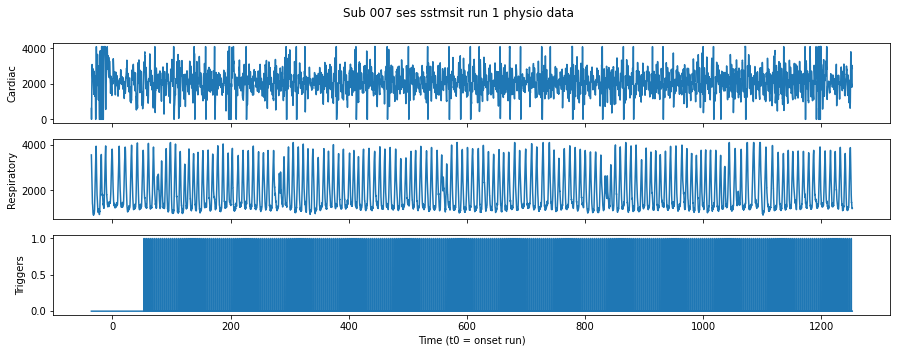

In [105]:
# plot physio of sub 7 ses ssstmsit to check error
#glob.glob('/home/Public/trondheim/')

fn_cardiac = '/home/Public/trondheim/derivatives/bids/sub-007/ses-sstmsit/func/sub-007_ses-sstmsit_task-msit_run-1_recording-cardiac_physio.tsv.gz'

physio = downsample_align_physio_fake(fn_cardiac, fn_cardiac.replace('cardiac', 'respiratory'))
f, ax = plt.subplots(3,1, sharex=True, figsize=(15,5))
ax[0].plot(physio['time'], physio['cardiac'])
ax[1].plot(physio['time'], physio['respiratory'].ffill())
ax[2].plot(physio['time'], physio['trigger'])
ax[0].set_ylabel('Cardiac')
ax[1].set_ylabel('Respiratory')
ax[2].set_ylabel('Triggers')
ax[2].set_xlabel('Time (t0 = onset run)')

regex = re.compile('.*/sub-(?P<subject_n>\d+)/ses-(?P<session_n>\S+)/func/sub-.*_run-(?P<run>\d).*')
gd = regex.match(fn_cardiac).groupdict()

f.suptitle('Sub {} ses {} run {} physio data'.format(gd['subject_n'], gd['session_n'], gd['run']))

559
559


Text(0.5, 0.98, 'Sub 004 ses sstmsit run 1 physio data')

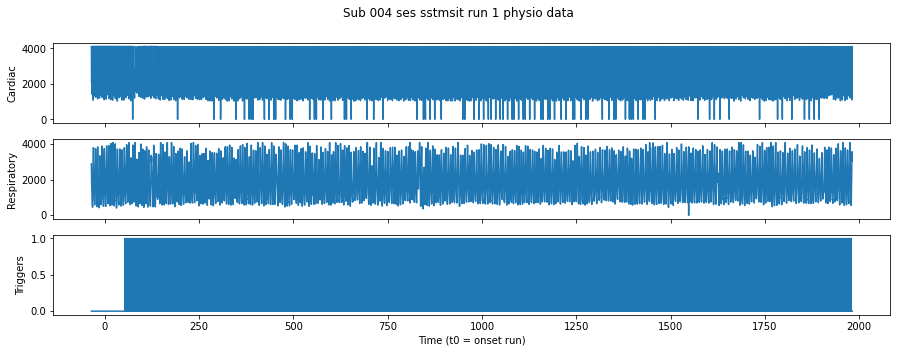

In [50]:
fn_cardiac = '/home/Public/trondheim/derivatives/bids/sub-004/ses-sstmsit/func/sub-004_ses-sstmsit_task-msit_run-1_recording-cardiac_physio.tsv.gz'

physio = downsample_align_physio_fake(fn_cardiac, fn_cardiac.replace('cardiac', 'respiratory'))
f, ax = plt.subplots(3,1, sharex=True, figsize=(15,5))
ax[0].plot(physio['time'], physio['cardiac'])
ax[1].plot(physio['time'], physio['respiratory'].ffill())
ax[2].plot(physio['time'], physio['trigger'])
ax[0].set_ylabel('Cardiac')
ax[1].set_ylabel('Respiratory')
ax[2].set_ylabel('Triggers')
ax[2].set_xlabel('Time (t0 = onset run)')

regex = re.compile('.*/sub-(?P<subject_n>\d+)/ses-(?P<session_n>\S+)/func/sub-.*_run-(?P<run>\d).*')
gd = regex.match(fn_cardiac).groupdict()

f.suptitle('Sub {} ses {} run {} physio data'.format(gd['subject_n'], gd['session_n'], gd['run']))

In [48]:
physio

,time,trigger,cardiac,respiratory
0,-35.682,0,610.0,3554.0
1,-35.632,0,285.0,3491.0
2,-35.582,0,65.0,3429.0
3,-35.532,0,0.0,3373.0
4,-35.482,0,0.0,3310.0
...,...,...,...,...
25757,1252.168,0,3025.0,1198.0
25758,1252.218,0,2999.0,1210.0
25759,1252.268,0,2958.0,1210.0
25760,1252.318,0,2913.0,1210.0


In [104]:
def downsample_align_physio_fake(cardiac_fn, respiratory_fn):
    cardiac = load_physio(cardiac_fn) #[::4]  ## Respiratory has 4x higher sampling rate
    respiratory = load_physio(respiratory_fn)
    print(respiratory)
#     if (cTrig := cardiac.trigger.sum()) != (rTrig := respiratory.trigger.sum()):
#         raise IOError(f'Not equal numbers of triggers found: cardiac: {cTrig}, respiratory: {rTrig}')
    print(cardiac.trigger.sum())
    print(respiratory.trigger.sum())
    # "simple" downsample by taking every fourth sample from the cardiac data
    cardiac = cardiac[::4]
    physio = pd.merge(cardiac, respiratory, on='time').reset_index(drop=True)
    #physio = pd.merge(respiratory, cardiac, on='time').reset_index(drop=True)
    physio['trigger'] = physio['trigger_y']
    
    physio = physio[['time', 'trigger', 'cardiac', 'respiratory']]
    return physio

In [56]:
from nilearn import plotting
import nibabel as nib
lol = nib.load('/home/Public/trondheim/sourcedata/zipdata/sub-007/ses-sstmsit/nifti_tmp/SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210218134022_11.nii.gz').get_data()

<ipython-input-56-8580478c63a4>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  lol = nib.load('/home/Public/trondheim/sourcedata/zipdata/sub-007/ses-sstmsit/nifti_tmp/SCANS_alt1_cmrr_ep2d_b_p3_s2_gre_ap_20210218134022_11.nii.gz').get_data()


In [57]:
lol.shape

(128, 128, 82, 559)

In [78]:
((27*53)+ 
(15.625*6)+
22.6875+
19.24803+
19.683+
2.7439+
(8*2)+
20.796875)/66

24.63498946969697

In [79]:
1.5*1.5*1.5

3.375

In [84]:
211/8

26.375

In [ ]:
# manually combine the sub-003_ses-anatomical respiratory and cardiac traces

# for run in [1,2]:
#     deriv = '../derivatives/bids/sub-003/ses-anatomical/func/sub-003_ses-anatomical_task-rs_run-{}'.format(run)
#     physio = downsample_align_physio(deriv + '_recording-cardiac_physio.tsv.gz', deriv + '_recording-respiratory_physio.tsv.gz')
#     physio = physio.fillna(method='ffill')  # forward fill missing values
#     physio[['cardiac', 'respiratory', 'trigger']].to_csv(deriv + '_physio.tsv.gz', sep='\t', header = None, index=False)
#     physio_sidecar = {'StartTime': physio['time'].iloc[0],  # was reset to align with first trigger
#                       'SamplingFrequency': 50,  # Hz, from respiratory
#                       'Columns': ['cardiac', 'respiratory', 'trigger']}
#     with open(deriv + '_physio.json', 'w') as f:
#         json.dump(physio_sidecar, f)

In [ ]:
# #     ('sub-003', 'ses-anatomical'),
# #     ('sub-002', 'ses-rlsat'),
# #     ('sub-002', 'ses-rbrevl'),
# #      ('sub-004', 'ses-anatomical'),
# #      ('sub-005', 'ses-anatomical'),
# #      ('sub-006', 'ses-anatomical'),
# #     ('sub-005', 'ses-rlsat'),
# #     ('sub-007', 'ses-anatomical'),
# #     ('sub-008', 'ses-anatomical')
#     ('sub-003', 'ses-rbrevl'),
# #      ('sub-002', 'ses-sstmsit'),
# #     ('sub-005', 'ses-rlsat')
#     ('sub-005', 'ses-rbrevl'),
# #     ('sub-009', 'ses-anatomical')
# #     ('sub-003', 'ses-rlsat'),
# #      ('sub-005', 'ses-sstmsit'),
# #     ('sub-006', 'ses-sstmsit'),
#     ('sub-007', 'ses-sstmsit'),
# #     ('sub-002', 'ses-anatomical'),
# #     ('sub-011', 'ses-anatomical')
# #         ('sub-007', 'ses-rlsat'),
# #         ('sub-006', 'ses-rlsat'),
# #        ('sub-009', 'ses-sstmsit'),
# #        ('sub-010', 'ses-anatomical'),
# #        ('sub-011', 'ses-rlsat')
# #     ('sub-012', 'ses-anatomical'),
# #     ('sub-013', 'ses-anatomical'),
# #     ('sub-014', 'ses-anatomical'),
# #     ('sub-015', 'ses-anatomical'),
# #     ('sub-016', 'ses-anatomical'),
# #     ('sub-008', 'ses-sstmsit')
# #       ('sub-010', 'ses-sstmsit'),
# #     ('sub-009', 'ses-rbrevl'),
# #     ('sub-009', 'ses-rlsat'),
# #     ('sub-015', 'ses-sstmsit'),
# #     ('sub-010', 'ses-rlsat')
# #      ('sub-018', 'ses-anatomical'),
# #      ('sub-019', 'ses-anatomical')
#        ('sub-012', 'ses-rlsat'),
# #         ('sub-013','ses-rbrevl'),
# #         ('sub-016', 'ses-sstmsit'),
# #         ('sub-017', 'ses-anatomical'),
# #         ('sub-017', 'ses-rlsat'),
# #         ('sub-019', 'ses-rbrevl')
# #     ('sub-020', 'ses-anatomical'),
# #     ('sub-004', 'ses-rlsat'),
# #     ('sub-016', 'ses-rlsat'),
# #     ('sub-018', 'ses-rlsat'),
# #     ('sub-013', 'ses-sstmsit'),
# #     ('sub-020', 'ses-rbrevl'),
# #     ('sub-012', 'ses-sstmsit'),
# #     ('sub-014', 'ses-rbrevl'),
# #     ('sub-017', 'ses-rbrevl'),
# #     ('sub-019', 'ses-sstmsit'),
# #     ('sub-021', 'ses-anatomical'),
# #     ('sub-015', 'ses-rbrevl')
#     ('sub-006', 'ses-rbrevl'),
#     ('sub-008', 'ses-rbrevl'),
#     ('sub-012', 'ses-sstmsit'),
#       ('sub-019', 'ses-rlsat'),
#       ('sub-020', 'ses-rlsat'),
#       ('sub-004', 'ses-rbrevl'),
#       ('sub-011', 'ses-rbrevl'),
#       ('sub-018', 'ses-sstmsit'),
#       ('sub-014', 'ses-rlsat'),
#       ('sub-017', 'ses-sstmsit'),
#     ('sub-013', 'ses-rlsat')
#     ('sub-020','ses-sstmsit'),
#     ('sub-016','ses-rbrevl'),
#     ('sub-011','ses-sstmsit')
#     ('sub-023','ses-anatomical'),
#         ('sub-024','ses-anatomical'),
#         ('sub-026','ses-anatomical'),